# Visualization Portal for:
## Revealing the Spatial Shifting Patterns of COVID-19 Pandemic in the United States.
### Di Zhu, Xinyue Ye, Steven Manson (2021), Scientific Reports. DOI : 10.1038/s41598-021-87902-8 b1496e8c-d2f6-44a0-ad87-06c43bad8ca8
#### Code written based on the paper: Di Zhu, Zhou Huang, Li Shi, Lun Wu & Yu Liu (2018) Inferring spatial interaction patterns from sequential snapshots of spatial distributions, International Journal of Geographical Information Science, 32:4, 783-805, DOI: 10.1080/13658816.2017.1413192 https://doi.org/10.1080/13658816.2017.1413192 and the demo code in https://github.com/dizhu-gis/IIDS-Inferring_Interactions_from_Distribution_Snapshots
© Copyright 2021, Di Zhu 

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import numpy as np
import libpysal as lp
import seaborn as sns
import matplotlib.pyplot as plt
from splot.libpysal import plot_spatial_weights
import copy

import matplotlib.colors as colors
import networkx as nx
import matplotlib as mpl
from matplotlib import cm

from matplotlib.ticker import MultipleLocator
import os

from sklearn import preprocessing

from scipy.stats import linregress
from scipy.stats import spearmanr

In [39]:
def initialize_gis(t1,t2):
    state=gpd.read_file('./COUNTY_dis2/COUNTY_dis2.shp')
    # state.head(5)
    columns=['STATE_FIPS','STATE_NAME','SUM_POP2_1','geometry']
    state_df=state[columns]
    state_df=state_df.dropna()
    pop_gdp=pd.read_csv('./COUNTY_dis2/state_pop_GDP_2019.csv')
    pop_gdp.columns=['Name','Postal Code','FIPS','POP2019','GDP2019million']

    state_df=state_df.merge(pop_gdp,left_on='STATE_NAME',right_on='Name',how='inner')[['STATE_FIPS','STATE_NAME','geometry','SUM_POP2_1','POP2019','GDP2019million']]


    covdf1=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/'+t1+'_2020.csv')
    covdf2=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/'+t2+'_2020.csv')

    columns_2=['FIPS','Province_State','Confirmed','Deaths']
    covdf1=covdf1[columns_2]
    covdf2=covdf2[columns_2]

    confirmed1=state_df.merge(covdf1,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    death1=state_df.merge(covdf1,left_on='STATE_NAME',right_on='Province_State',how="inner")['Deaths']
    confirmed2=state_df.merge(covdf2,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    death2=state_df.merge(covdf2,left_on='STATE_NAME',right_on='Province_State',how="inner")['Deaths']

    state_df['confirmed1']=confirmed1
    state_df['confirmed2']=confirmed2
    state_df['death1']=death1
    state_df['death2']=death2

    scalar=confirmed1.sum()/confirmed2.sum()
    state_df['confirmed1_scaled']=confirmed1/scalar
    state_df.confirmed2.sum(),state_df.confirmed1_scaled.sum()
    return state_df

def plot_pops_distributions(state_df,t1,t2):
    f,ax=plt.subplots(1,3,figsize=(25,10))
    ax0=state_df.plot(column='POP2019',scheme='Quantiles',cmap='Blues',k=12,legend=False,ax=ax[0])
    ax1=state_df.plot(column='confirmed1_scaled',scheme='Quantiles',k=12,cmap='Reds',legend=False,ax=ax[1])
    ax2=state_df.plot(column='confirmed2',scheme='Quantiles',k=12,cmap='Reds',legend=False,ax=ax[2])
    ax[0].set_title('Population')
    ax[1].set_title(t1)
    ax[2].set_title(t2)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()

    # add colorbar
    fig0 = ax0.get_figure()
    cax0 = fig0.add_axes([0.34, 0.35, 0.01, 0.2])
    sm0 = plt.cm.ScalarMappable(cmap='Blues', 
                                norm=colors.SymLogNorm(linthresh=1,linscale=1,
                                                    vmin=state_df.POP2019.min(), vmax=state_df.POP2019.max(),base=10))
    fig0.colorbar(sm0, cax=cax0)
    # add colorbar
    fig1 = ax1.get_figure()
    cax1 = fig1.add_axes([0.62, 0.35, 0.01, 0.2])
    sm1 = plt.cm.ScalarMappable(cmap='Reds', 
                                norm=colors.SymLogNorm(linthresh=1,linscale=1,
                                                    vmin=state_df.confirmed1.min(), vmax=state_df.confirmed1.max(),base=10))
    fig1.colorbar(sm1, cax=cax1)
    # add colorbar

    fig2 = ax2.get_figure()
    cax2 = fig2.add_axes([0.9, 0.35, 0.01, 0.2])
    sm2 = plt.cm.ScalarMappable(cmap='Reds', 
                                norm=colors.SymLogNorm(linthresh=1,linscale=1,
                                                    vmin=state_df.confirmed2.min(), vmax=state_df.confirmed2.max(),base=10))
    fig2.colorbar(sm2, cax=cax2)
    # plt.savefig('./Fig_results_twitter/'+t1+'_to_'+t2+'distribution.png',dpi=200,bbox_inches='tight')

def plot_twitter_flows(state_df,t1,t2):
    twitter_mat=np.loadtxt('./movementmatricesbetweenstates/FormattedTwitterOD/2020.'+t1+'~'+t2+'.csv',delimiter=',',skiprows=0)
    twitter_mat=twitter_mat.astype(int)
    f,ax=plt.subplots(1,1,figsize=(15,15))
    w = lp.weights.full2W(twitter_mat)
    # Create graph
    G = nx.MultiDiGraph(format='png', directed=True)

    names=np.arange(0,state_df.shape[0]).tolist()

    positions=[]
    for p in state_df.geometry.centroid:
        positions.append((p.x,p.y))

    edges=[]
    points=w.full()[0].nonzero()
    flowmat=w.full()[0]
    for e in range(0,w.nonzero):
        fromid=points[0][e]
        toid=points[1][e]
        weights=flowmat[fromid,toid]
        edges.append((fromid,toid,weights))

    for index, name in enumerate(names):
        G.add_node(name, pos=positions[index])
    G.add_weighted_edges_from(edges)

    M = G.number_of_edges()



    node_sizes = np.log(state_df.confirmed2)**1.5
    node_alphas=0.75

    edge_weights=np.array(edges)[:,2]
    edge_colors = np.log10(edge_weights).tolist()
    # edge_alphas = np.log10(edge_weights)/np.log10(max(edge_weights))
    edge_alphas = 0.8

    nodes_ax = nx.draw_networkx_nodes(G, positions, node_size=node_sizes, node_color='white',ax=ax,alpha=0.2)
    # edges_ax = nx.draw_networkx_edges(G, positions, node_size=node_sizes, arrowstyle='->',
    #                                arrowsize=20, edge_color='red',
    #                                edge_cmap=plt.cm.OrRd, width=edge_weights/8000,ax=ax)
    edges_ax = nx.draw_networkx_edges(G, positions, node_size=node_sizes, arrowstyle='->',
                                   arrowsize=20, edge_color=edge_colors,
                                   edge_cmap=plt.cm.GnBu, width=4*np.log10(edge_weights)/np.log10(max(edge_weights)),ax=ax)
    # # set alpha value for each edge
    for i in range(M):
        edges_ax[i].set_alpha(edge_alphas)


    # pc = mpl.collections.PatchCollection(edges_ax, cmap=plt.cm.OrRd)
    # pc.set_array([min(edge_weights),max(edge_weights)])
    # f.colorbar(pc,ax=ax)

    ax1=state_df.plot(ax=ax,alpha=0.7,color='lightgrey',edgecolor='white',linewidth=1)

    
    fig1 = ax1.get_figure()
    cax1 = fig1.add_axes([0.85, 0.32, 0.02, 0.25])
    sm1 = mpl.collections.PatchCollection(edges_ax, cmap=plt.cm.GnBu,
                                             norm=colors.SymLogNorm(linthresh=1, linscale=1,vmin=min(edge_weights),vmax=max(edge_weights),base=10))
    fig1.colorbar(sm1, cax=cax1)
    

    ax.set_title(t1+' to '+t2)
    ax.set_axis_off()
    # plt.savefig('./Fig_results_twitter/TwitterOD_'+t1+'_'+t2+'.png',dpi=200,bbox_inches='tight')

def plot_twitterOD_matrix(state_df,t1,t2):
    cost_matrix=np.loadtxt('./movementmatricesbetweenstates/FormattedTwitterOD/2020.'+t1+'~'+t2+'.csv',delimiter=',',skiprows=0)
    f,ax=plt.subplots(1,1,figsize=(22,22))
    ax1=sns.heatmap(cost_matrix,ax=ax,cmap='GnBu',linecolor='white',linewidths=.3,cbar = False,norm=colors.SymLogNorm(linthresh=1, linscale=1, base=10))

    ax.set_xticklabels(state_df.STATE_NAME.values,rotation=90,fontsize=18)
    ax.set_yticklabels(state_df.STATE_NAME.values,rotation=0,fontsize=18)
    # ax[1].set_title(t1+' to '+t2,fontsize=20)
    ax.set_ylabel('From',fontsize=50)
    ax.set_xlabel('To',fontsize=50)
    
    # add colorbar
    fig1 = ax1.get_figure()
    cax1 = fig1.add_axes([0.93, 0.13, 0.02, 0.6])
    sm1 = plt.cm.ScalarMappable(cmap='GnBu', 
                                norm=colors.SymLogNorm(linthresh=1,linscale=1,
                                                    vmin=cost_matrix.min(), vmax=cost_matrix.max(),base=10))
    fig1.colorbar(sm1, cax=cax1)
    # plt.savefig('./Fig_results_twitter/TwitterOD_'+t1+'_'+t2+'_Mat.png',dpi=200,bbox_inches='tight')

def plot_twitterflow_box():
    flow_matrixs=[]
    flow_matrix=np.loadtxt("./movementmatricesbetweenstates/FormattedTwitterOD/2020.01-31~03-13.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./movementmatricesbetweenstates/FormattedTwitterOD/2020.03-13~03-31.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./movementmatricesbetweenstates/FormattedTwitterOD/2020.03-31~04-28.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./movementmatricesbetweenstates/FormattedTwitterOD/2020.04-28~06-11.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./movementmatricesbetweenstates/FormattedTwitterOD/2020.06-11~07-23.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix5)
    flow_matrix6=np.loadtxt("./movementmatricesbetweenstates/FormattedTwitterOD/2020.07-23~08-09.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix6)
    
    labels=['P1','P2','P3','P4','P5','P6']
    colors=['green']
    
    
    tbs=[]
    for i,phase in enumerate(labels):
        tb=pd.DataFrame(flow_matrixs[i])
        tb['Phase']=phase
        tbs.append(tb)
        
    data_tbs=pd.concat(tbs,axis=0)
    data_tbs=data_tbs.reset_index()[[0,'Phase']]
    data_tbs.columns=[r'Twitter_flows','Phase']
    data_tbs=data_tbs[data_tbs[r'Twitter_flows'] > 0]
    f,ax=plt.subplots(1,1,figsize=(5,5))
    sns.boxplot(x='Phase',y=r'Twitter_flows',data=data_tbs,\
                   fliersize=0,linewidth=1,boxprops=dict(alpha=0.85),\
                   palette=colors,whis=1.5,ax=ax)
    sns.stripplot(x='Phase',y=r'Twitter_flows', data=data_tbs, color='black',edgecolor='white',alpha=0.5,size=4,linewidth=0.5,ax=ax)
    # ax.set_yticklabels(['Self-only','Adjacency','Taxi O-D'])
    # ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'])
    # sns.despine(trim=False)
    ax.set_yscale('log')
    ax.set_ylabel(r'Twitter Flows')
    ax.set_xlabel(' ')
#     ax.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)
    return data_tbs
    
    
def plot_cost_matrix(state_df,t1,t2):
    cost_matrix=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_"+t1+'_'+t2+".csv",delimiter=',',skiprows=0)
    f,ax=plt.subplots(1,1,figsize=(22,22))
    ax1=sns.heatmap(cost_matrix,ax=ax,cmap='seismic_r',linecolor='white',linewidths=.3,cbar = False,norm=colors.SymLogNorm(linthresh=1, linscale=1, base=10))

    ax.set_xticklabels(state_df.STATE_NAME.values,rotation=90,fontsize=18)
    ax.set_yticklabels(state_df.STATE_NAME.values,rotation=0,fontsize=18)
    # ax[1].set_title(t1+' to '+t2,fontsize=20)
    ax.set_ylabel('From',fontsize=50)
    ax.set_xlabel('To',fontsize=50)
    
    # add colorbar
    fig1 = ax1.get_figure()
    cax1 = fig1.add_axes([0.93, 0.13, 0.02, 0.6])
    sm1 = plt.cm.ScalarMappable(cmap='seismic_r', 
                                norm=colors.SymLogNorm(linthresh=1,linscale=1,
                                                    vmin=cost_matrix.min(), vmax=cost_matrix.max(),base=10))
    fig1.colorbar(sm1, cax=cax1)
    # plt.savefig('./Fig_results_twitter/TwitterOD_'+t1+'_'+t2+'_twittergravitycost_hm.png',dpi=200,bbox_inches='tight')

def plot_flows(state_df,t1,t2):
    flowmatrix=np.loadtxt("./Flow_Matrix_Twitter_"+t1+"_to_"+t2+".csv",delimiter=',',skiprows=0)
    f,ax=plt.subplots(1,1,figsize=(15,15))
    w = lp.weights.full2W(flowmatrix)
    # Create graph
    G = nx.MultiDiGraph(format='png', directed=True)

    names=np.arange(0,state_df.shape[0]).tolist()

    positions=[]
    for p in state_df.geometry.centroid:
        positions.append((p.x,p.y))

    edges=[]
    points=w.full()[0].nonzero()
    flowmat=w.full()[0]
    for e in range(0,w.nonzero):
        fromid=points[0][e]
        toid=points[1][e]
        weights=flowmat[fromid,toid]
        edges.append((fromid,toid,weights))

    for index, name in enumerate(names):
        G.add_node(name, pos=positions[index])
    G.add_weighted_edges_from(edges)

    M = G.number_of_edges()



    node_sizes = np.log(state_df.confirmed2)**2
    node_alphas=0.75

    edge_weights=np.array(edges)[:,2]
    edge_colors = np.log10(edge_weights).tolist()
    # edge_alphas = np.log10(edge_weights)/np.log10(max(edge_weights))
    edge_alphas = 0.8

    nodes_ax = nx.draw_networkx_nodes(G, positions, node_size=node_sizes, node_color='darkgrey',ax=ax,alpha=0.7)
    # edges_ax = nx.draw_networkx_edges(G, positions, node_size=node_sizes, arrowstyle='->',
    #                                arrowsize=20, edge_color='red',
    #                                edge_cmap=plt.cm.OrRd, width=edge_weights/8000,ax=ax)
    edges_ax = nx.draw_networkx_edges(G, positions, node_size=node_sizes, arrowstyle='->',
                                   arrowsize=25, edge_color=edge_colors,
                                   edge_cmap=plt.cm.OrRd, width=8*np.log10(edge_weights)/np.log10(max(edge_weights)),ax=ax)
    # # set alpha value for each edge
    for i in range(M):
        edges_ax[i].set_alpha(edge_alphas)


    # pc = mpl.collections.PatchCollection(edges_ax, cmap=plt.cm.OrRd)
    # pc.set_array([min(edge_weights),max(edge_weights)])
    # f.colorbar(pc,ax=ax)

    ax1=state_df.plot(ax=ax,alpha=0.7,color='lightgrey',edgecolor='white',linewidth=1)

    
    fig1 = ax1.get_figure()
    cax1 = fig1.add_axes([0.85, 0.32, 0.02, 0.25])
    sm1 = mpl.collections.PatchCollection(edges_ax, cmap=plt.cm.OrRd,
                                             norm=colors.SymLogNorm(linthresh=1, linscale=1,vmin=min(edge_weights),vmax=max(edge_weights),base=10))
    fig1.colorbar(sm1, cax=cax1)
    

    ax.set_title(t1+' to '+t2)
    ax.set_axis_off()

def plot_flow_matrix(state_df,t1,t2):
    flowmatrix=np.loadtxt("./Flow_Matrix_Twitter_"+t1+"_to_"+t2+".csv",delimiter=',',skiprows=0)
    f,ax=plt.subplots(1,1,figsize=(22,22))
    ax1=sns.heatmap(flowmatrix,ax=ax,cmap='OrRd',linecolor='white',linewidths=.3,cbar = False,norm=colors.SymLogNorm(linthresh=1, linscale=1, base=10))

    ax.set_xticklabels(state_df.STATE_NAME.values,rotation=90,fontsize=18)
    ax.set_yticklabels(state_df.STATE_NAME.values,rotation=0,fontsize=18)
    # ax[1].set_title(t1+' to '+t2,fontsize=20)
    ax.set_ylabel('From',fontsize=50)
    ax.set_xlabel('To',fontsize=50)
    
    # add colorbar
    fig1 = ax1.get_figure()
    cax1 = fig1.add_axes([0.93, 0.13, 0.02, 0.6])
    sm1 = plt.cm.ScalarMappable(cmap='OrRd', 
                                norm=colors.SymLogNorm(linthresh=1,linscale=1,
                                                    vmin=flowmatrix.min(), vmax=flowmatrix.max(),base=10))
    fig1.colorbar(sm1, cax=cax1)
    # plt.savefig('Fig_results_twitter/TwitterOD_'+t1+'_'+t2+'IIDShm.png',dpi=200,bbox_inches='tight')

def plot_stats_dis_shift():
    flow_matrixs=[]
    flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)/scales[0]
    flow_matrix=flow_matrix.tolist()
    flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)/scales[1]
    flow_matrix2=flow_matrix2.tolist()
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)/scales[2]
    flow_matrix3=flow_matrix3.tolist()
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)/scales[3]
    flow_matrix4=flow_matrix4.tolist()
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)/scales[4]
    flow_matrix5=flow_matrix5.tolist()
    flow_matrixs.append(flow_matrix5)
    flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)/scales[5]
    flow_matrix6=flow_matrix6.tolist()
    flow_matrixs.append(flow_matrix6)
    labels=['P1','P2','P3','P4','P5','P6']
    # read distance matrix
    distance=np.genfromtxt('distancematrix_states/matrix_states.csv',delimiter=',',dtype=None)
    
    colors=['lightgrey','skyblue','orange','violet','red','black']
    f,ax=plt.subplots(1,1,figsize=(5,5))
    for i in range(0,len(flow_matrixs)):
        sns.scatterplot(np.log10(np.array(flow_matrixs[i]).flatten()[np.where(np.array(flow_matrixs[i]).flatten()!=0)]),
                    np.log10(np.array(distance).flatten()[np.where(np.array(flow_matrixs[i]).flatten()!=0)]),
                    s=180,alpha=0.6,color=colors[i],label=labels[i],ax=ax,edgecolor='white')
    # ax.set_xscale('log')
    ax.set_xlabel(r'$log_{10}$'+'(Daily Shifts)')
    ax.set_ylabel(r'$log_{10}$'+'Distance')
    # ax.set_yscale('log')
    ax.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)

    # plt.savefig('Fig_results_twitter/Stats/scatter_dis_shift.png',dpi=200,bbox_inches='tight')

def plot_stats_shiftcdf():
    flow_matrixs=[]
    flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)/scales[0]
    flow_matrix=flow_matrix.tolist()
    flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)/scales[1]
    flow_matrix2=flow_matrix2.tolist()
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)/scales[2]
    flow_matrix3=flow_matrix3.tolist()
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)/scales[3]
    flow_matrix4=flow_matrix4.tolist()
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)/scales[4]
    flow_matrix5=flow_matrix5.tolist()
    flow_matrixs.append(flow_matrix5)
    flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)/scales[5]
    flow_matrix6=flow_matrix6.tolist()
    flow_matrixs.append(flow_matrix6)
    labels=['P1','P2','P3','P4','P5','P6']
    colors=['lightgrey','skyblue','orange','violet','red','black']
    f,ax=plt.subplots(1,1,figsize=(5,5))
    kwargs = {'cumulative': True,'linewidth': 4,'alpha':0.7}
    for i in range(0,len(flow_matrixs)):
        x=np.delete(np.array(flow_matrixs[i]).flatten(), np.where(np.array(flow_matrixs[i]).flatten()==0))
        sns.distplot(np.log10(x), rug=True, hist=False, kde_kws=kwargs,bins=48,ax=ax,label=labels[i],color=colors[i])

    ax.set_ylim([-0.1,1.1])
    ax.set_xlabel(r'$log_{10}$'+'(Daily Shifts)')
    ax.set_ylabel(r'CDF(Daily SRs)')
    plt.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)
    # plt.savefig('Fig_results_twitter/Stats/CDF_logshift.png',dpi=200,bbox_inches='tight')

def plot_stats_weightedshift_cdf():
    flow_matrixs=[]
    flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)/scales[0]
    flow_matrix=flow_matrix.tolist()
    flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)/scales[1]
    flow_matrix2=flow_matrix2.tolist()
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)/scales[2]
    flow_matrix3=flow_matrix3.tolist()
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)/scales[3]
    flow_matrix4=flow_matrix4.tolist()
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)/scales[4]
    flow_matrix5=flow_matrix5.tolist()
    flow_matrixs.append(flow_matrix5)
    flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)/scales[5]
    flow_matrix6=flow_matrix6.tolist()
    flow_matrixs.append(flow_matrix6)
    labels=['P1','P2','P3','P4','P5','P6']
    # read distance matrix
    distance=np.genfromtxt('distancematrix_states/matrix_states.csv',delimiter=',',dtype=None)
    colors=['lightgrey','skyblue','orange','violet','red','black']
    f,ax=plt.subplots(1,1,figsize=(5,5))
    kwargs = {'cumulative': True,'linewidth': 4,'alpha':0.7}
    for i in range(0,len(flow_matrixs)):
        data=np.multiply(distance,np.array(flow_matrixs[i])) # weighting func
        x=np.delete(data.flatten(), np.where(data.flatten()==0))
        sns.distplot(np.log10(x), rug=True, hist=False , kde_kws=kwargs,bins=48,ax=ax,label=labels[i],color=colors[i])

    ax.set_ylim([-0.1,1.1])
    ax.set_xlabel(r'$log_{10}$'+'(Weighted Daily Shifts)')
    ax.set_ylabel(r'CDF(Weighted Daily Shifts)')
    plt.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)
    # plt.savefig('Fig_results_twitter/Stats/CDF_logshift_distweighted.png',dpi=200,bbox_inches='tight')

def plot_cost_shifts():
    cost_matrixs=[]
    cost_matrix=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_01-31_03-13.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix)
    cost_matrix2=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_03-13_03-31.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix2)
    cost_matrix3=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_03-31_04-28.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix3)
    cost_matrix4=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_04-28_06-11.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix4)
    cost_matrix5=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_06-11_07-23.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix5)
    cost_matrix6=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_07-23_08-09.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix6)
    
    flow_matrixs=[]
    flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)/scales[0]
    flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)/scales[1]
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)/scales[2]
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)/scales[3]
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)/scales[4]
    flow_matrixs.append(flow_matrix5)
    flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)/scales[5]
    flow_matrixs.append(flow_matrix6)
    
    
    labels=['P1','P2','P3','P4','P5','P6']
    colors=['lightgrey','skyblue','orange','violet','red','black']
    
#     hist_kwargs={"histtype": "step", "linewidth": 1,
#                             "alpha": 1}
#     kde_kws={"lw": 3, "label": "KDE"}
    
    f,ax=plt.subplots(1,1,figsize=(5,5))
    
    for i in range(0,len(cost_matrixs)):
        data_x=np.array(cost_matrixs[i]).flatten() 
        data_y=np.array(flow_matrixs[i]).flatten() 
#         data_x=np.delete(data_x.flatten(), np.where(data_x.flatten()>=1e6))
#         data_x=preprocessing.scale(data_x)
        sns.scatterplot(data_x,np.log10(data_y),s=180,alpha=0.7,color=colors[i],label=labels[i],ax=ax,edgecolor='white')
    ax.set_xlabel(r'Cost')
    ax.set_ylabel(r'$log_{10}$(Daily Shifts)')
#    ax.set_xscale('log')
#     ax.set_yscale('log')
    plt.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)

def plot_flow_hist():
    flow_matrixs=[]
    flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)/scales[0]
    flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)/scales[1]
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)/scales[2]
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)/scales[3]
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)/scales[4]
    flow_matrixs.append(flow_matrix5)
    flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)/scales[5]
    flow_matrixs.append(flow_matrix6)
    
    
    labels=['P1','P2','P3','P4','P5','P6']
    colors=['lightgrey','skyblue','orange','violet','red','black']
    
    hist_kwargs={"histtype": "step", "linewidth": 2,
                            "alpha": 0.8}
    kde_kws={"lw": 3,"alpha":0.6}
    
    f,ax=plt.subplots(1,1,figsize=(5,5))
    
    for i in range(0,len(flow_matrixs)):
        data_x=np.array(flow_matrixs[i]) 
        data_x=np.delete(data_x.flatten(), np.where(data_x.flatten()==0))
#         data_x=preprocessing.scale(data_x)
        sns.distplot(np.log10(data_x),rug=False, hist=True,kde=True,bins=10,kde_kws=kde_kws,hist_kws=hist_kwargs,ax=ax,label=labels[i],color=colors[i])

    ax.set_xlabel(r'$log_{10}$(Daily Shifts)')
    ax.set_ylabel(r'Density')
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.set_ylim([-10000,10000])
#     ax.set_xlim([5,1e4])
    plt.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)
    
def plot_case_ts():
    path='./covid_19_daily_reports_20200121_0811_State/reports/'
    files=os.listdir(path)
    files=sorted(files)[1:]
    # for file in files:
    #     print(file)
    covdf_ts=pd.DataFrame()
    for file in files:
        covdf_ts=pd.concat([covdf_ts,pd.read_csv(path+file)])
    covdf_ts['date']=[ i[:-5] for i in covdf_ts['Last_Update']]

    data_ts=covdf_ts.groupby('date').sum()

    data_ts['date_simple']=[i[5:] for i in data_ts.index.values]

    data_ts=data_ts[10:]
    f,ax=plt.subplots(1,1,figsize=(18,5))
    colors=['lightgrey','skyblue','orange','violet','red','black']
    count=0
    for i,period in enumerate(scales):
            sns.scatterplot(range(count,count+period),data_ts.Confirmed[count:count+period],
                            ax=ax,color=colors[i],s=25,marker='o',alpha=1)
            count+=period
    ax2=sns.scatterplot([0,42,60,88,132,174,191],data_ts.Confirmed[[0,42,60,88,132,174,191]].values,
                        ax=ax,s=175,marker='d',color='white',alpha=1,edgecolor='black')

    ax.xaxis.set_minor_locator(MultipleLocator(7))
    ax.set_xlim([-1,192])
    ax.set_ylabel('Total Confirmed Cases')
    # ax.set_yscale('log')
    sns.despine(offset=30, left=0)
    # scales=[42,18,28,44,42,17]
    plt.xticks([0,42,60,88,132,174,191],(['Jan 31','Mar 13','Mar 31','Apr 28','Jun 11','Jul 23','Aug 09']),fontsize=20)


def plot_stats_shift_GDP(state_df):
    flow_matrixs=[]
    flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix5)
    flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix6)
    labels=['P1','P2','P3','P4','P5','P6']
    # read confirmed case
    
    gdp=state_df.GDP2019million.values
    colors=['lightgrey','skyblue','orange','violet','red','black']
    f,ax=plt.subplots(1,1,figsize=(5,5))
    flowsall=[]
    results=[]
    for i in range(0,len(flow_matrixs)):
        flows=flow_matrixs[i].sum(axis=1)+flow_matrixs[i].sum(axis=0)
        flowsall.append(flows.flatten().tolist())
#         print(flows.shape[0])
#         print(deltaconfirmedcases.shape[0])
        sns.scatterplot(np.log10(flows),np.log10(gdp),
                    s=100,alpha=0.7,color=colors[i],label=labels[i],ax=ax,edgecolor='white')
        sns.regplot(np.log10(flows+1),np.log10(gdp),
                scatter=False,color=colors[i],line_kws={'lw':3,'alpha':1},ci=95,ax=ax)
        r=linregress(np.log10(flows+1),np.log10(gdp))
        results.append(r)
#     ax.set_xscale('log') #
    ax.set_xlabel(r'$log_{10}$'+'(Shifts)')
    ax.set_ylabel(r'$log_{10}$'+'(GDP)')
#     ax.set_yscale('log')
#     ax.set_xlim([0.0,6])
#     ax.set_ylim([0.0,6])
#     sns.regplot(np.log10(np.array(sum(flowsall,[]))+1),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1),
#                 scatter=False,color='Navy',line_kws={'lw':3,'alpha':1},ci=100,ax=ax)
#     result=linregress(np.log10(np.array(sum(flowsall,[]))+1),np.log10(gdp))
    ax.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)
    return results

def plot_stats_dailyshift_next_dailydeltaconfirmedcase(state_df):
    flow_matrixs=[]
    flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)/scales[0]
    flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)/scales[1]
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)/scales[2]
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)/scales[3]
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)/scales[4]
    flow_matrixs.append(flow_matrix5)
    flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)/scales[5]
    flow_matrixs.append(flow_matrix6)
    labels=['S1-C2','S2-C3','S3-C4','S4-C5','S5-C6']
    # read confirmed case
    
    covdfs=[]
    covdf1=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/01-31_2020.csv')
    confirmed=state_df.merge(covdf1,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf2=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/03-13_2020.csv')
    confirmed=state_df.merge(covdf2,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf3=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/03-31_2020.csv')
    confirmed=state_df.merge(covdf3,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf4=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/04-28_2020.csv')
    confirmed=state_df.merge(covdf4,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf5=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/06-11_2020.csv')
    confirmed=state_df.merge(covdf5,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf6=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/07-23_2020.csv')
    confirmed=state_df.merge(covdf6,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf7=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/08-09_2020.csv')
    confirmed=state_df.merge(covdf7,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    colors=['skyblue','orange','violet','red','black']
    f,ax=plt.subplots(1,1,figsize=(5,5))
    flowsall=[]
    deltaconfirmedcasesall=[]
    for i in range(0,len(flow_matrixs)-1):
        flows=flow_matrixs[i].sum(axis=1)+flow_matrixs[i].sum(axis=0)
        deltaconfirmedcases=(covdfs[i+2]-covdfs[i+1]).values/scales[i+1]
        flowsall.append(flows.flatten().tolist())
        deltaconfirmedcasesall.append(deltaconfirmedcases.flatten().tolist())
#         print(flows.shape[0])
#         print(deltaconfirmedcases.shape[0])
        sns.scatterplot(np.log10(flows+1),np.log10(deltaconfirmedcases+1),
                    s=100,alpha=0.7,color=colors[i],label=labels[i],ax=ax,edgecolor='white')
#     ax.set_xscale('log') #
    ax.set_xlabel(r'$log_{10}$'+'(Daily Shifts)')
    ax.set_ylabel(r'$log_{10}$'+'(Daily $\Delta$$CCs$)')
#     ax.set_yscale('log')
#     ax.set_xlim([0.0,6])
#     ax.set_ylim([0.0,6])
    sns.regplot(np.log10(np.array(sum(flowsall,[]))+1),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1),
                scatter=False,color='Deeppink',line_kws={'lw':3,'alpha':1},ci=100,ax=ax)
    rresult=linregress(np.log10(np.array(sum(flowsall,[]))+1),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1))
    presult=spearmanr(np.log10(np.array(sum(flowsall,[]))+1),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1))
    ax.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)
    return rresult,presult

def plot_stats_shift_deltaconfirmedcase(state_df):
    flow_matrixs=[]
    flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix5)
    flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix6)
    labels=['P1','P2','P3','P4','P5','P6']
    # read confirmed case
    
    covdfs=[]
    covdf1=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/01-31_2020.csv')
    confirmed=state_df.merge(covdf1,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf2=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/03-13_2020.csv')
    confirmed=state_df.merge(covdf2,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf3=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/03-31_2020.csv')
    confirmed=state_df.merge(covdf3,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf4=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/04-28_2020.csv')
    confirmed=state_df.merge(covdf4,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf5=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/06-11_2020.csv')
    confirmed=state_df.merge(covdf5,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf6=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/07-23_2020.csv')
    confirmed=state_df.merge(covdf6,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf7=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/08-09_2020.csv')
    confirmed=state_df.merge(covdf7,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    colors=['lightgrey','skyblue','orange','violet','red','black']
    f,ax=plt.subplots(1,1,figsize=(5,5))
    flowsall=[]
    deltaconfirmedcasesall=[]
    for i in range(0,len(flow_matrixs)):
        flows=flow_matrixs[i].sum(axis=1)+flow_matrixs[i].sum(axis=0)
        deltaconfirmedcases=(covdfs[i+1]-covdfs[i]).values
        flowsall.append(flows.flatten().tolist())
        deltaconfirmedcasesall.append(deltaconfirmedcases.flatten().tolist())
#         print(flows.shape[0])
#         print(deltaconfirmedcases.shape[0])
        sns.scatterplot(np.log10(flows+1),np.log10(deltaconfirmedcases+1),
                    s=100,alpha=0.7,color=colors[i],label=labels[i],ax=ax,edgecolor='white')
#     ax.set_xscale('log') #
    ax.set_xlabel(r'$log_{10}$'+'(Shifts)')
    ax.set_ylabel(r'$log_{10}$'+'($\Delta$$CCs$)')
#     ax.set_yscale('log')
#     ax.set_xlim([0.0,6])
#     ax.set_ylim([0.0,6])
    sns.regplot(np.log10(np.array(sum(flowsall,[]))+1),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1),
                scatter=False,color='DeepPink',line_kws={'lw':3,'alpha':1},ci=100,ax=ax)
    rresult=linregress(np.log10(np.array(sum(flowsall,[]))+1),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1))
    presult=spearmanr(np.log10(np.array(sum(flowsall,[]))+1),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1))
    ax.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)
    return rresult,presult

def plot_stats_Inshift_deltaconfirmedcase(state_df):
    flow_matrixs=[]
    flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix5)
    flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix6)
    labels=['P1','P2','P3','P4','P5','P6']
    # read confirmed case
    
    covdfs=[]
    covdf1=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/01-31_2020.csv')
    confirmed=state_df.merge(covdf1,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf2=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/03-13_2020.csv')
    confirmed=state_df.merge(covdf2,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf3=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/03-31_2020.csv')
    confirmed=state_df.merge(covdf3,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf4=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/04-28_2020.csv')
    confirmed=state_df.merge(covdf4,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf5=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/06-11_2020.csv')
    confirmed=state_df.merge(covdf5,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf6=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/07-23_2020.csv')
    confirmed=state_df.merge(covdf6,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf7=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/08-09_2020.csv')
    confirmed=state_df.merge(covdf7,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    colors=['lightgrey','skyblue','orange','violet','red','black']
    f,ax=plt.subplots(1,1,figsize=(5,5))
    flowsall=[]
    deltaconfirmedcasesall=[]
    for i in range(0,len(flow_matrixs)):
        flows=flow_matrixs[i].sum(axis=0) # inflow
        flows=flows[np.where(flows!=0)]
        deltaconfirmedcases=(covdfs[i+1]-covdfs[i]).values
        deltaconfirmedcases=deltaconfirmedcases[np.where(flows!=0)]
        flowsall.append(flows.flatten().tolist())
        deltaconfirmedcasesall.append(deltaconfirmedcases.flatten().tolist())
#         print(flows.shape[0])
#         print(deltaconfirmedcases.shape[0])
        sns.scatterplot(np.log10(flows),np.log10(deltaconfirmedcases+1),
                    s=100,alpha=0.7,color=colors[i],label=labels[i],ax=ax,edgecolor='white')
#     ax.set_xscale('log') #
    ax.set_xlabel(r'$log_{10}$'+'(In-Shifts)')
    ax.set_ylabel(r'$log_{10}$'+'($\Delta$$CCs$)')
#     ax.set_yscale('log')
#     ax.set_xlim([0.0,6])
#     ax.set_ylim([0.0,6])
    sns.regplot(np.log10(np.array(sum(flowsall,[]))),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1),
                scatter=False,color='DeepPink',line_kws={'lw':3,'alpha':1},ci=100,ax=ax)
    result=linregress(np.log10(np.array(sum(flowsall,[]))),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1))
    presult=spearmanr(np.log10(np.array(sum(flowsall,[]))),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1))
    ax.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)
    return result,presult

def plot_stats_Outshift_deltaconfirmedcase(state_df):
    flow_matrixs=[]
    flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix5)
    flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)
    flow_matrixs.append(flow_matrix6)
    labels=['P1','P2','P3','P4','P5','P6']
    # read confirmed case
    
    covdfs=[]
    covdf1=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/01-31_2020.csv')
    confirmed=state_df.merge(covdf1,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf2=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/03-13_2020.csv')
    confirmed=state_df.merge(covdf2,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf3=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/03-31_2020.csv')
    confirmed=state_df.merge(covdf3,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf4=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/04-28_2020.csv')
    confirmed=state_df.merge(covdf4,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf5=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/06-11_2020.csv')
    confirmed=state_df.merge(covdf5,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf6=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/07-23_2020.csv')
    confirmed=state_df.merge(covdf6,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    covdf7=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/08-09_2020.csv')
    confirmed=state_df.merge(covdf7,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
    covdfs.append(confirmed)
    
    colors=['lightgrey','skyblue','orange','violet','red','black']
    f,ax=plt.subplots(1,1,figsize=(5,5))
    flowsall=[]
    deltaconfirmedcasesall=[]
    for i in range(0,len(flow_matrixs)):
        flows=flow_matrixs[i].sum(axis=1) # outflow
        flows=flows[np.where(flows!=0)]
        deltaconfirmedcases=(covdfs[i+1]-covdfs[i]).values
        deltaconfirmedcases=deltaconfirmedcases[np.where(flows!=0)]
        flowsall.append(flows.flatten().tolist())
        deltaconfirmedcasesall.append(deltaconfirmedcases.flatten().tolist())
#         print(flows.shape[0])
#         print(deltaconfirmedcases.shape[0])
        sns.scatterplot(np.log10(flows),np.log10(deltaconfirmedcases+1),
                    s=100,alpha=0.7,color=colors[i],label=labels[i],ax=ax,edgecolor='white')
#     ax.set_xscale('log') #
    ax.set_xlabel(r'$log_{10}$'+'(Out-Shifts)')
    ax.set_ylabel(r'$log_{10}$'+'($\Delta$$CCs$)')
#     ax.set_yscale('log')
#     ax.set_xlim([0.0,6])
#     ax.set_ylim([0.0,6])
    sns.regplot(np.log10(np.array(sum(flowsall,[]))),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1),
                scatter=False,color='DeepPink',line_kws={'lw':3,'alpha':1},ci=100,ax=ax)
    result=linregress(np.log10(np.array(sum(flowsall,[]))),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1))
    presult=spearmanr(np.log10(np.array(sum(flowsall,[]))),np.log10(np.array(sum(deltaconfirmedcasesall,[]))+1))
    ax.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)
    return result,presult



def plot_inshifts_outshifts(state_df):
    flow_matrixs=[]
    flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)/scales[0]
    flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)/scales[1]
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)/scales[2]
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)/scales[3]
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)/scales[4]
    flow_matrixs.append(flow_matrix5)
    flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)/scales[5]
    flow_matrixs.append(flow_matrix6)
    labels=['P1','P2','P3','P4','P5','P6']
    # read confirmed case
    names=state_df.STATE_NAME.values
    names_plot=['New York','California','Texas','Florida','Georgia','Illinois','New Jersey']
    
    colors=['lightgrey','skyblue','orange','violet','red','black']
    f,ax=plt.subplots(1,1,figsize=(5,5))
    
    for i in range(0,len(flow_matrixs)):
        outflows=flow_matrixs[i].sum(axis=1)# outflow
        inflows=flow_matrixs[i].sum(axis=0) # inflow
        g=sns.scatterplot(np.log10(inflows+1),np.log10(outflows+1),
                    s=50,alpha=0.6,color=colors[i],label=labels[i],ax=ax,edgecolor='white')
#         for j,name in enumerate(names):
#             if(name in names_plot):
#                  g.text(np.log10(inflows+1)[j]+0.08, np.log10(outflows+1)[j], name,horizontalalignment='left', size=5, weight='normal',color=colors[i])
#     ax.set_xscale('log') #
    ax.set_xlabel(r'$log_{10}$'+'(Daily In-Shifts)')
    ax.set_ylabel(r'$log_{10}$'+'(Daily Out-Shifts)')
#     ax.set_yscale('log')
#     ax.set_xlim([0.0,6])
#     ax.set_ylim([0.0,6])
    ax.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)
    
def plot_inflow_matrix_one_city(state_df,cityname):
    flow_matrixs=[]
#     flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)/scales[0]
#     flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)/scales[1]
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)/scales[2]
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)/scales[3]
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)/scales[4]
    flow_matrixs.append(flow_matrix5)
#     flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)/scales[5]
#     flow_matrixs.append(flow_matrix6)
    
    f,ax=plt.subplots(1,1,figsize=(20,1.7))
    index=0
    for i, name in enumerate(namelist):
        if name==cityname:
            index = i
    ODs=np.stack((flow_matrixs[0][:,index],
                 flow_matrixs[1][:,index],
                 flow_matrixs[2][:,index],
                 flow_matrixs[3][:,index]),axis=0)
    ax1=sns.heatmap(ODs,ax=ax,cmap='OrRd',linecolor='white',linewidths=0.3,cbar = False,norm=colors.SymLogNorm(linthresh=1, linscale=1, base=10))

    ax.set_xticklabels(state_df.STATE_NAME.values,rotation=90,fontsize=15)
#     ax.set_yticklabels(['O','D'],rotation=0,fontsize=18)
    # ax[1].set_title(t1+' to '+t2,fontsize=20)
    ax.set_ylabel('In-Shifts',fontsize=30)
    ax.set_xlabel('Source',fontsize=30)
    
    # add colorbar
    fig1 = ax1.get_figure()
    cax1 = fig1.add_axes([0.92, 0.12, 0.02, 0.7])
    sm1 = plt.cm.ScalarMappable(cmap='OrRd', 
                                norm=colors.SymLogNorm(linthresh=1,linscale=1,
                                                    vmin=ODs.min(), vmax=ODs.max(),base=10))
    fig1.colorbar(sm1, cax=cax1)
    # plt.savefig('Fig_results_twitter/TwitterOD_'+t1+'_'+t2+'IIDShm.png',dpi=200,bbox_inches='tight')
    
def plot_outflow_matrix_one_city(state_df,cityname):
    flow_matrixs=[]
#     flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)/scales[0]
#     flow_matrixs.append(flow_matrix)
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)/scales[1]
    flow_matrixs.append(flow_matrix2)
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)/scales[2]
    flow_matrixs.append(flow_matrix3)
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)/scales[3]
    flow_matrixs.append(flow_matrix4)
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)/scales[4]
    flow_matrixs.append(flow_matrix5)
#     flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)/scales[5]
#     flow_matrixs.append(flow_matrix6)
    
    f,ax=plt.subplots(1,1,figsize=(20,1.7))
    index=0
    for i, name in enumerate(namelist):
        if name==cityname:
            index = i
    ODs=np.stack((flow_matrixs[0][index,:],
                 flow_matrixs[1][index,:],
                 flow_matrixs[2][index,:],
                 flow_matrixs[3][index,:]),axis=0)
    ax1=sns.heatmap(ODs,ax=ax,cmap='GnBu',linecolor='white',linewidths=0.3,cbar = False,norm=colors.SymLogNorm(linthresh=1, linscale=1, base=10))

    ax.set_xticklabels(state_df.STATE_NAME.values,rotation=90,fontsize=15)
#     ax.set_yticklabels(['O','D'],rotation=0,fontsize=18)
    # ax[1].set_title(t1+' to '+t2,fontsize=20)
    ax.set_ylabel('Out-Shifts',fontsize=30)
    ax.set_xlabel('Target',fontsize=30)
    
    # add colorbar
    fig1 = ax1.get_figure()
    cax1 = fig1.add_axes([0.92, 0.12, 0.02, 0.7])
    sm1 = plt.cm.ScalarMappable(cmap='GnBu', 
                                norm=colors.SymLogNorm(linthresh=1,linscale=1,
                                                    vmin=ODs.min(), vmax=ODs.max(),base=10))
    fig1.colorbar(sm1, cax=cax1)
    # plt.savefig('Fig_results_twitter/TwitterOD_'+t1+'_'+t2+'IIDShm.png',dpi=200,bbox_inches='tight')

In [3]:
sns.set_context('poster')

In [4]:
# 1.31~3.13 # 42 days
# 3.13~3.31 # 18 days
# 3.31~4.28 # 28 days
# 4.28~6.11 # 44 days
# 6.11~7.23 # 42 days
# 7.23~8.09 # 17 days
scales=[42,18,28,44,42,17] # enable to normalize the risks to be the average 'daily risk'

t1='07-23'
t2='08-09'
state_df=initialize_gis(t1,t2)

### visualization calls

/Users/zhudi/miniconda3/envs/myconda/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmap=self.cmap, **kws)
/Users/zhudi/miniconda3/envs/myconda/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmap=self.cmap, **kws)


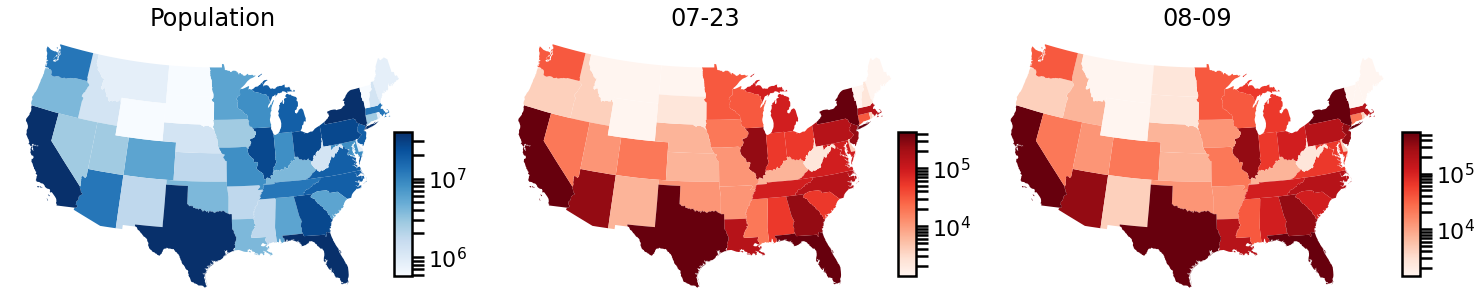

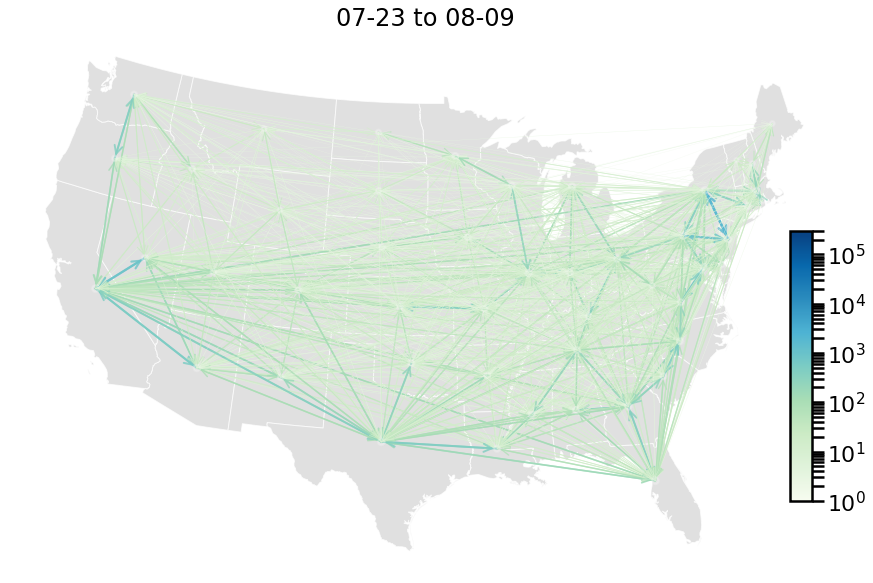

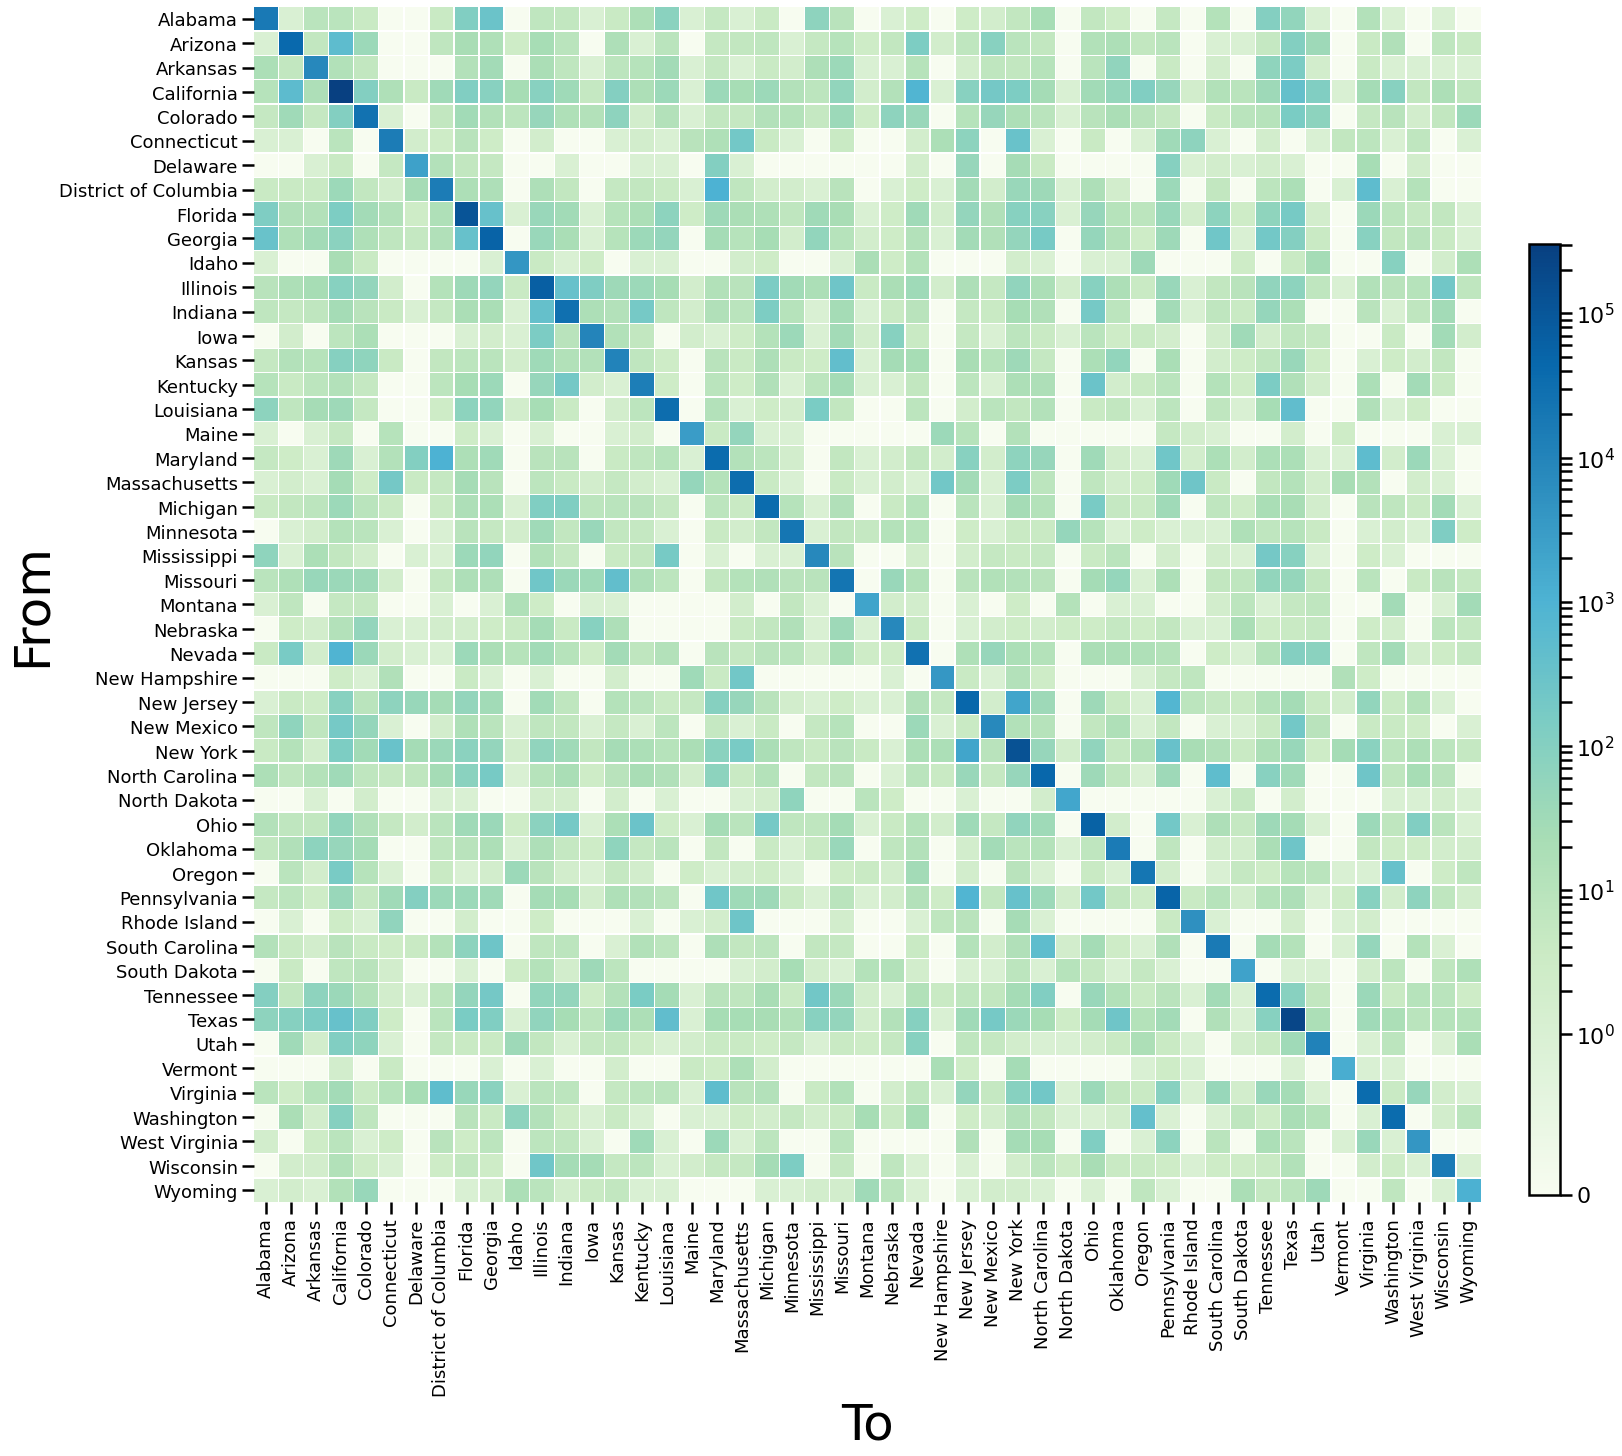

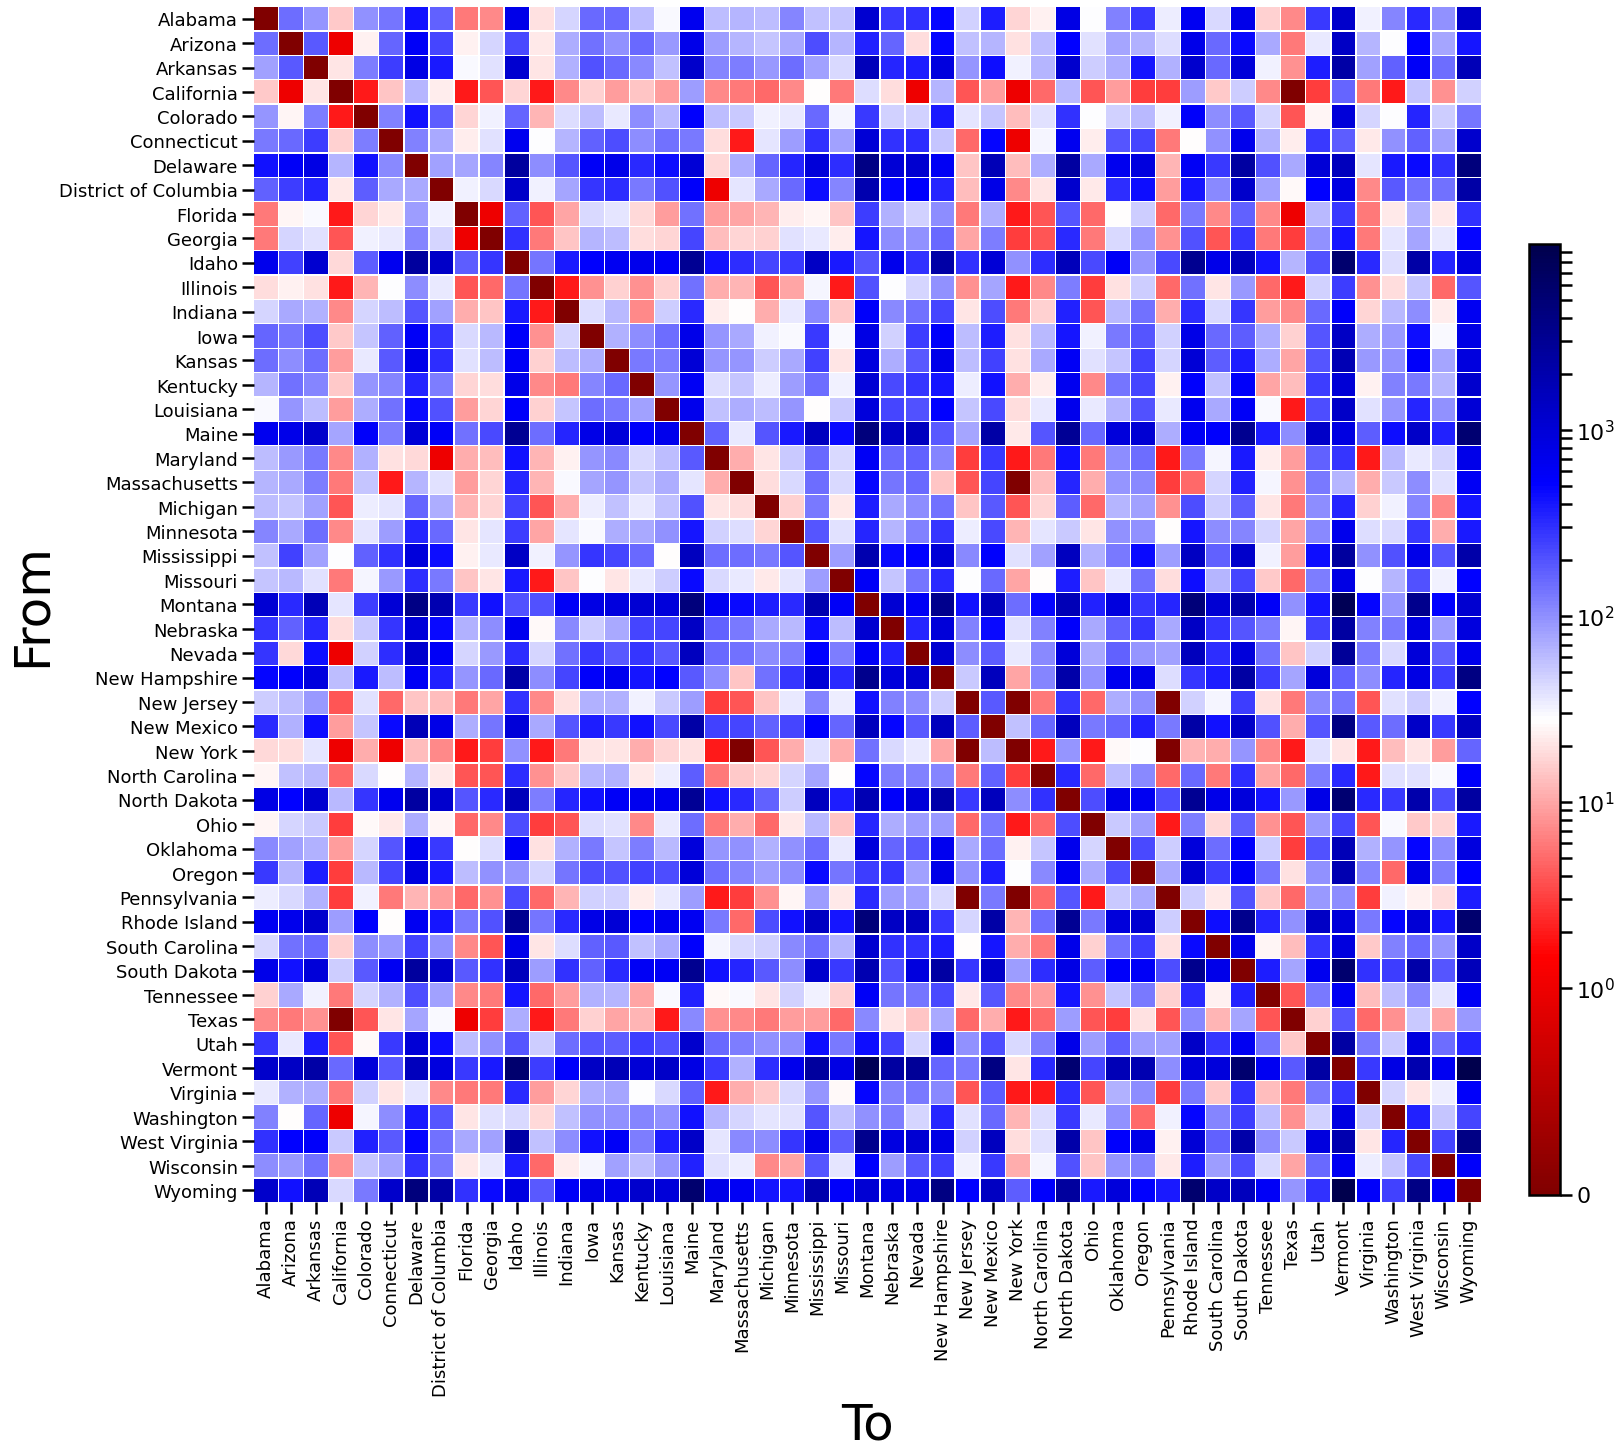

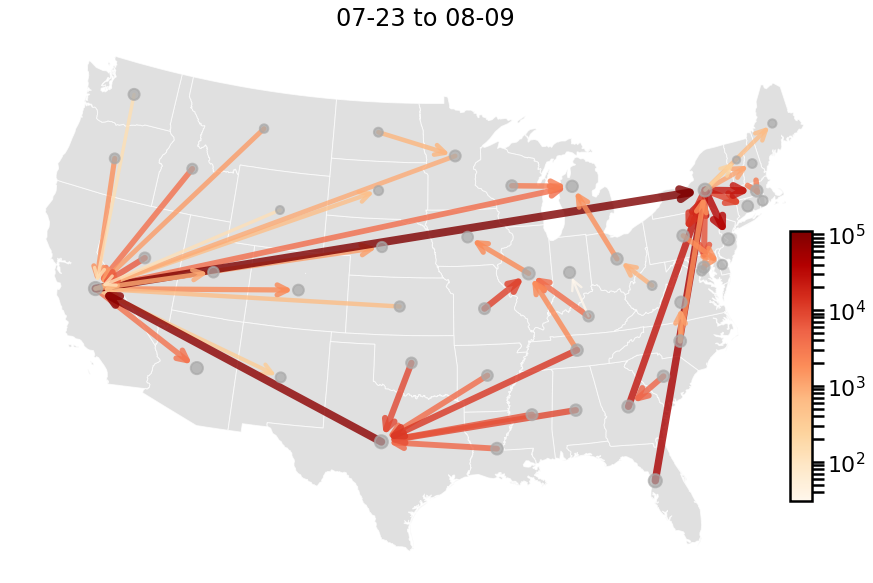

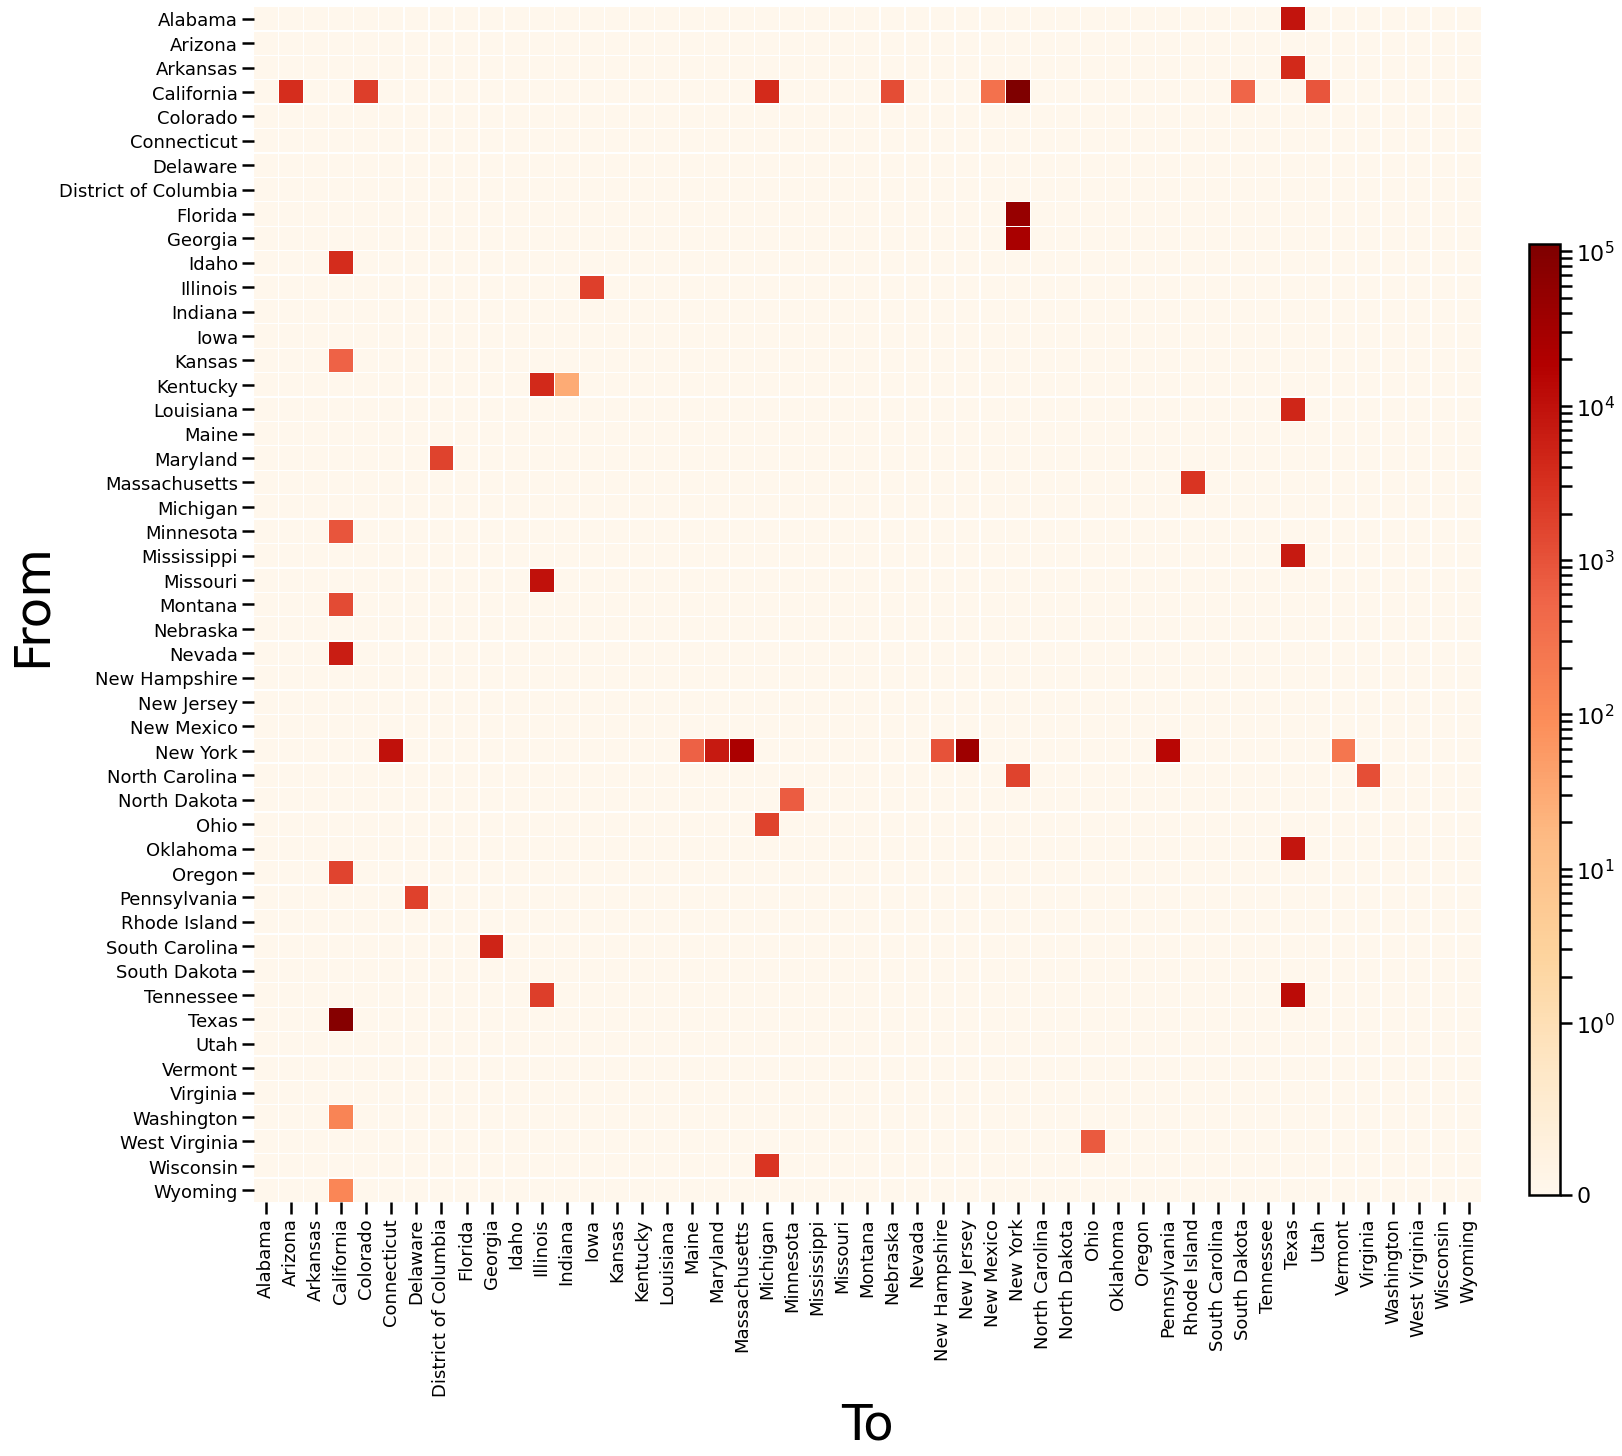

In [90]:
plot_pops_distributions(state_df,t1,t2)
plt.savefig('Fig_source_pnas/Distribution_'+t1+'_to_'+t2+'.png',dpi=200,bbox_inches='tight')

plot_twitter_flows(state_df,t1,t2)
plt.savefig('Fig_source_pnas/Twitterflow_'+t1+'_'+t2+'.png',dpi=200,bbox_inches='tight')

plot_twitterOD_matrix(state_df,t1,t2)
plt.savefig('Fig_source_pnas/TwitterMatrix_'+t1+'_'+t2+'.png',dpi=200,bbox_inches='tight')


plot_cost_matrix(state_df,t1,t2)
plt.savefig('Fig_source_pnas/CostMatrix_Adjusted_'+t1+'_'+t2+'.png',dpi=200,bbox_inches='tight')


plot_flows(state_df,t1,t2)
plt.savefig('Fig_source_pnas/Shifts_'+t1+'_'+t2+'.png',dpi=200,bbox_inches='tight')


plot_flow_matrix(state_df,t1,t2)
plt.savefig('Fig_source_pnas/ShiftsMatrix_'+t1+'_'+t2+'.png',dpi=200,bbox_inches='tight')

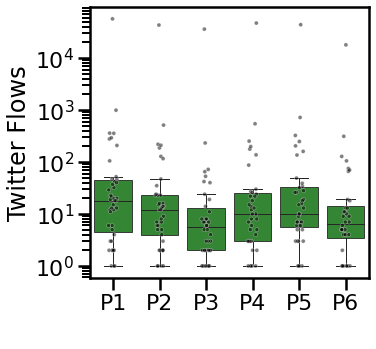

In [40]:
plot_twitterflow_box()
plt.savefig('Fig_source_pnas/Stats/twitterflows_boxplot.png',dpi=200,bbox_inches='tight')

/Users/zhudi/miniconda3/envs/myconda/lib/python3.7/site-packages/ipykernel_launcher.py:528: RuntimeWarning: divide by zero encountered in log10


0.531181704328159 4.6998828620797655 4.570125969248637e-13 0.8218540304003067
0.3221384354369647 4.491973048729317 1.2399471099983281e-06 0.6298813629862112
0.30533878229769823 4.422676518596187 2.693762834213751e-05 0.561549136036182
0.398764605403159 3.9532653209143156 5.301753471547629e-12 0.8000942573584647
0.3921489445626459 3.788450759844784 6.058923583046757e-10 0.748940833258166
0.38291165875053185 4.04605723115179 1.0645354645529824e-07 0.6746403454975998


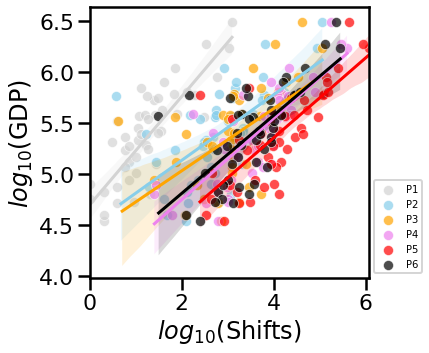

In [270]:
r=plot_stats_shift_GDP(state_df)
plt.savefig('Fig_source_pnas/Stats/GDP_logshift.png',dpi=200,bbox_inches='tight')
for rs in r:
    print(rs.slope,rs.intercept,rs.pvalue,rs.rvalue)

(0.46854431929524143,
 1.594826159515472,
 4.637715383786268e-40,
 0.7176506334671424,
 0.7494293073549683,
 2.0631330704779683e-45)

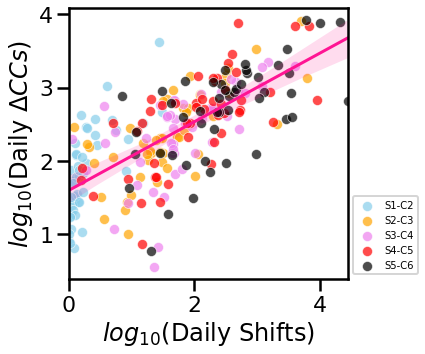

In [299]:
r,p=plot_stats_dailyshift_next_dailydeltaconfirmedcase(state_df)
plt.savefig('Fig_source_pnas/Stats/Cases_logshift_next.png',dpi=200,bbox_inches='tight')
r.slope,r.intercept,r.pvalue,r.rvalue,p.correlation,p.pvalue

(0.8505288829106872,
 0.728224900713299,
 2.684686969977381e-89,
 0.8646563476702077,
 0.8571225515701065,
 4.080584873299504e-86)

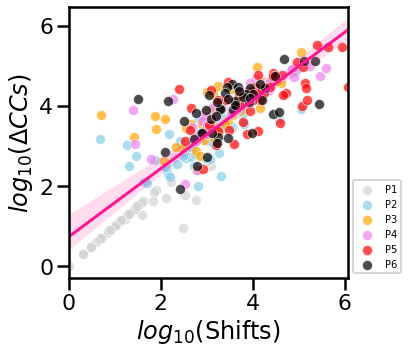

In [295]:
r,p=plot_stats_shift_deltaconfirmedcase(state_df)
plt.savefig('Fig_source_pnas/Stats/Cases_logshift.png',dpi=200,bbox_inches='tight')
r.slope,r.intercept,r.pvalue,r.rvalue,p.correlation,p.pvalue

(0.6764592387558199,
 1.2712392647224728,
 1.8227041484964556e-29,
 0.6801939961266084,
 0.5729912946829805,
 1.850997566557458e-19)

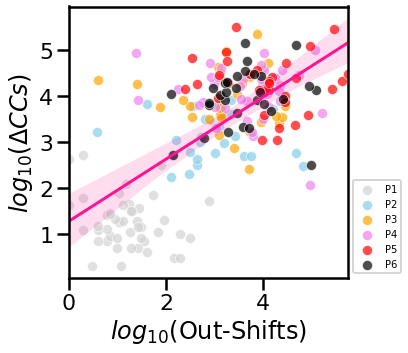

In [483]:
r,p=plot_stats_Outshift_deltaconfirmedcase(state_df)
plt.savefig('Fig_source_pnas/Stats/Cases_logOutshift.png',dpi=200,bbox_inches='tight')
r.slope,r.intercept,r.pvalue,r.rvalue,p.correlation,p.pvalue

(0.3776897539680433,
 2.4204041463248176,
 2.459984613435421e-07,
 0.42100889290724763,
 0.3472679155325411,
 2.8097371622435524e-05)

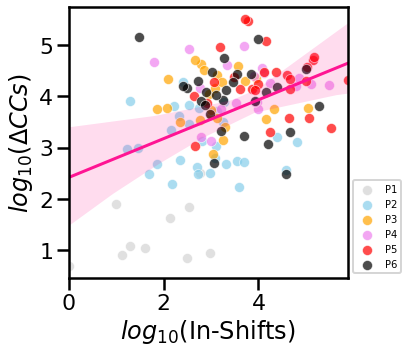

In [484]:
r,p=plot_stats_Inshift_deltaconfirmedcase(state_df)
plt.savefig('Fig_source_pnas/Stats/Cases_logInshift.png',dpi=200,bbox_inches='tight')
r.slope,r.intercept,r.pvalue,r.rvalue,p.correlation,p.pvalue

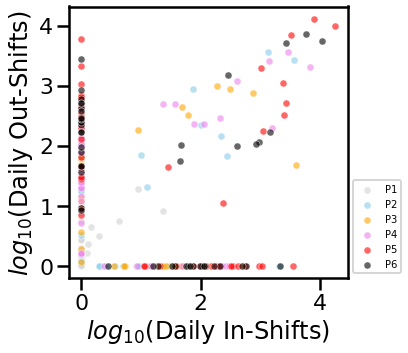

In [54]:
plot_inshifts_outshifts(state_df)
plt.savefig('Fig_source_pnas/Stats/In_out_shifts_nolabel.png',dpi=200,bbox_inches='tight')

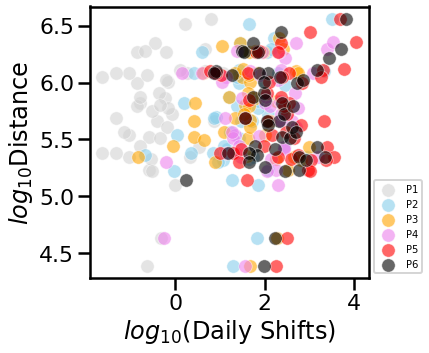

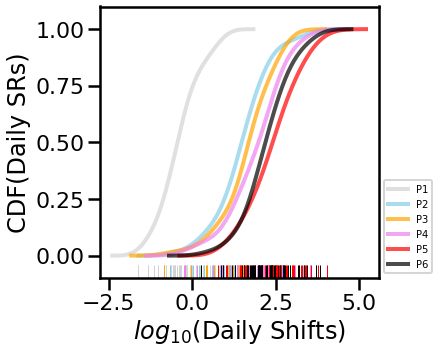

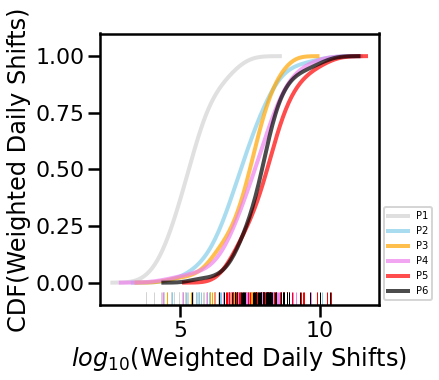

In [61]:
plot_stats_dis_shift()
plt.savefig('Fig_source_pnas/Stats/Dis_logshift.png',dpi=200,bbox_inches='tight')

plot_stats_shiftcdf()
plt.savefig('Fig_source_pnas/Stats/CDF_logshift.png',dpi=200,bbox_inches='tight')

plot_stats_weightedshift_cdf()
plt.savefig('Fig_source_pnas/Stats/CDF_logshift_distweighted.png',dpi=200,bbox_inches='tight')

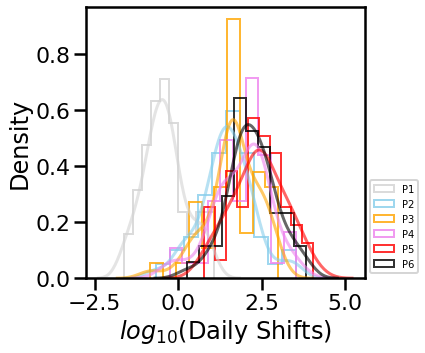

In [62]:
plot_flow_hist()
plt.savefig('Fig_source_pnas/Stats/Hist_logshift.png',dpi=200,bbox_inches='tight')

/Users/zhudi/miniconda3/envs/myconda/lib/python3.7/site-packages/ipykernel_launcher.py:420: RuntimeWarning: divide by zero encountered in log10


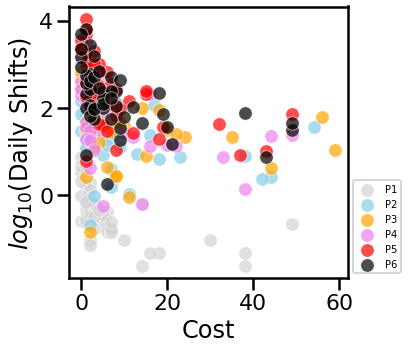

In [67]:
plot_cost_shifts()
plt.savefig('Fig_source_pnas/Stats/Cost_Logshift.png',dpi=200,bbox_inches='tight')

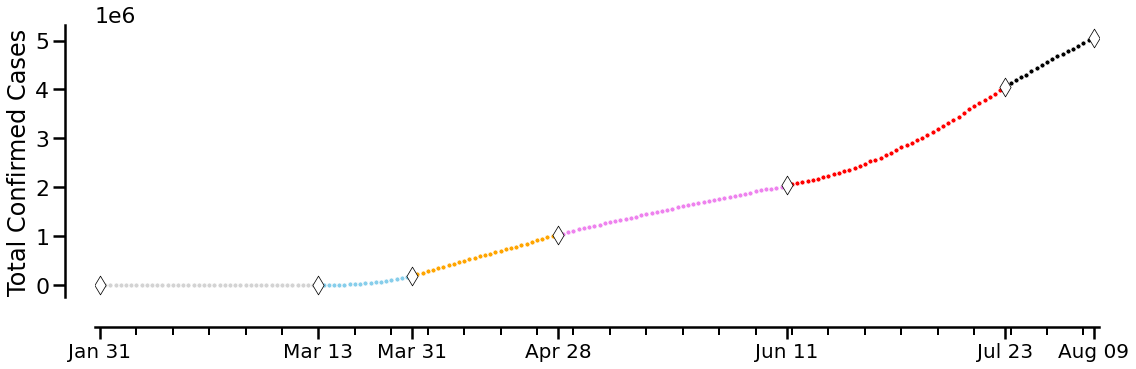

In [68]:
plot_case_ts()
plt.savefig('Fig_source_pnas/Stats/Cases_signature.png',dpi=200,bbox_inches='tight')

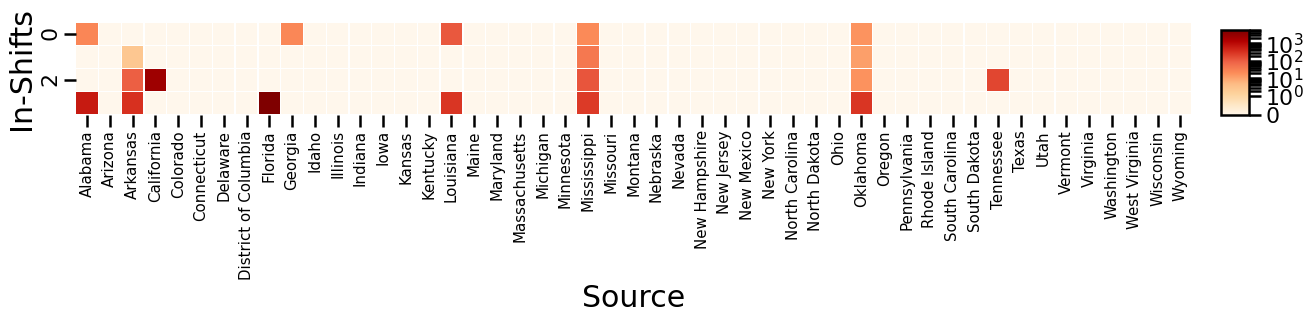

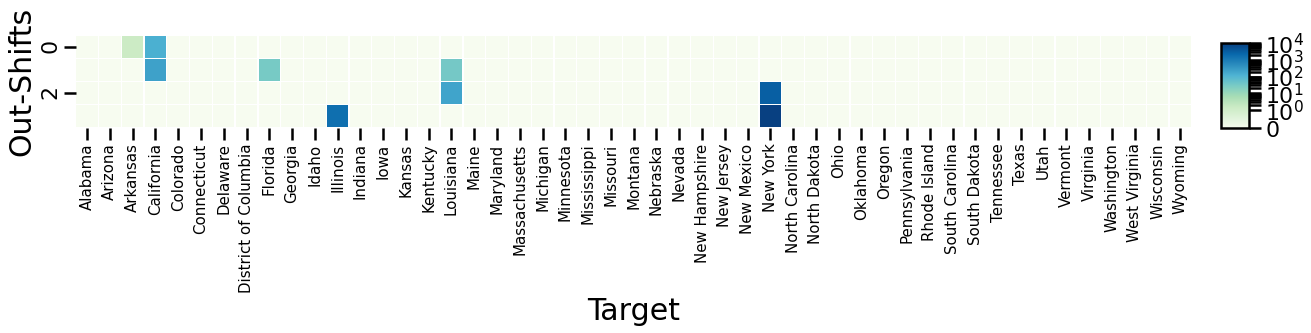

In [877]:
namelist=state_df.STATE_NAME.values
plot_inflow_matrix_one_city(state_df,'Texas')
# plt.savefig('Fig_source_pnas/NY_heatmap_in.png',dpi=200,bbox_inches='tight')
plot_outflow_matrix_one_city(state_df,'Texas')
# plt.savefig('Fig_source_pnas/NY_heatmap_out.png',dpi=200,bbox_inches='tight')

In [73]:
def plot_flows_daily(state_df,t1,t2,pid):
    flowmatrix=np.loadtxt("./Flow_Matrix_Twitter_"+t1+"_to_"+t2+".csv",delimiter=',',skiprows=0)/scales[pid]
    f,ax=plt.subplots(1,1,figsize=(10,10))
    w = lp.weights.full2W(flowmatrix)
    # Create graph
    G = nx.MultiDiGraph(format='png', directed=True)

    names=np.arange(0,state_df.shape[0]).tolist()

    positions=[]
    for p in state_df.geometry.centroid:
        positions.append((p.x,p.y))

    edges=[]
    points=w.full()[0].nonzero()
    flowmat=w.full()[0]
    for e in range(0,w.nonzero):
        fromid=points[0][e]
        toid=points[1][e]
        weights=flowmat[fromid,toid]
        edges.append((fromid,toid,weights))

    for index, name in enumerate(names):
        G.add_node(name, pos=positions[index])
    G.add_weighted_edges_from(edges)

    M = G.number_of_edges()



    node_sizes = np.log(state_df.confirmed2)**2
    node_alphas=0.75

    edge_weights=np.array(edges)[:,2]
    edge_colors = np.log10(edge_weights).tolist()
    # edge_alphas = np.log10(edge_weights)/np.log10(max(edge_weights))
    edge_alphas = 0.8

    nodes_ax = nx.draw_networkx_nodes(G, positions, node_size=node_sizes, node_color='darkgrey',ax=ax,alpha=0.7)
    # edges_ax = nx.draw_networkx_edges(G, positions, node_size=node_sizes, arrowstyle='->',
    #                                arrowsize=20, edge_color='red',
    #                                edge_cmap=plt.cm.OrRd, width=edge_weights/8000,ax=ax)
    edges_ax = nx.draw_networkx_edges(G, positions, node_size=node_sizes, arrowstyle='->',
                                   arrowsize=25, edge_color=edge_colors,
                                   edge_cmap=plt.cm.OrRd, width=12*np.log10(edge_weights)/np.log10(max(edge_weights)),ax=ax)
    # # set alpha value for each edge
    for i in range(M):
        edges_ax[i].set_alpha(edge_alphas)


    # pc = mpl.collections.PatchCollection(edges_ax, cmap=plt.cm.OrRd)
    # pc.set_array([min(edge_weights),max(edge_weights)])
    # f.colorbar(pc,ax=ax)

    ax1=state_df.plot(ax=ax,alpha=0.7,color='lightgrey',edgecolor='white',linewidth=1)
    state_df.query('STATE_NAME=="New York"').plot(ax=ax,alpha=0.4,color='black',edgecolor='white',linewidth=1)
    
    fig1 = ax1.get_figure()
    cax1 = fig1.add_axes([0.62, 0.17, 0.02, 0.22])
    sm1 = mpl.collections.PatchCollection(edges_ax, cmap=plt.cm.OrRd,
                                             norm=colors.SymLogNorm(linthresh=1, linscale=1,vmin=min(edge_weights),vmax=max(edge_weights),base=10))
    fig1.colorbar(sm1, cax=cax1)
    
    ax.set_xlim([0.9e6,2.5e6])
    ax.set_ylim([-0.2e6,1.2e6])
    ax.set_title(t1+' to '+t2)
    ax.set_axis_off()

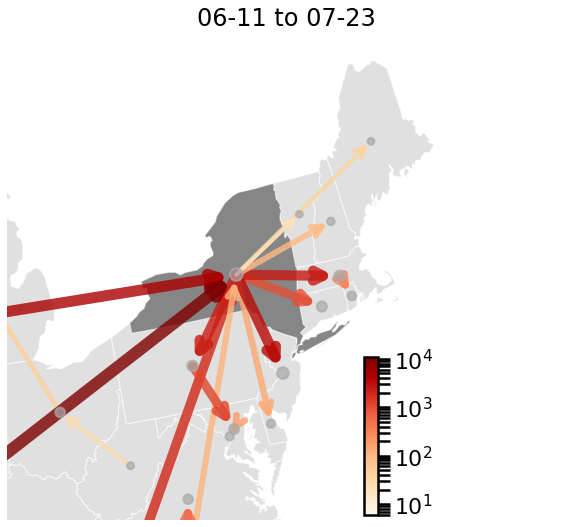

In [79]:
t1='06-11'
t2='07-23'
pid=4
plot_flows_daily(state_df,t1,t2,pid)
plt.savefig('Fig_source_pnas/NY_'+t1+'_'+t2+'.png',dpi=200,bbox_inches='tight')

In [485]:
def plot_cost_mul_shift_hist():
    cost_matrixs=[]
    cost_matrix=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_01-31_03-13.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix.flatten())
    cost_matrix2=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_03-13_03-31.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix2.flatten())
    cost_matrix3=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_03-31_04-28.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix3.flatten())
    cost_matrix4=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_04-28_06-11.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix4.flatten())
    cost_matrix5=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_06-11_07-23.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix5.flatten())
    cost_matrix6=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_07-23_08-09.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix6.flatten())

    flow_matrixs=[]
    flow_matrix=np.loadtxt("./Flow_Matrix_Twitter_01-31_to_03-13.csv",delimiter=',',skiprows=0)/scales[0]
    flow_matrixs.append(flow_matrix.flatten())
    flow_matrix2=np.loadtxt("./Flow_Matrix_Twitter_03-13_to_03-31.csv",delimiter=',',skiprows=0)/scales[1]
    flow_matrixs.append(flow_matrix2.flatten())
    flow_matrix3=np.loadtxt("./Flow_Matrix_Twitter_03-31_to_04-28.csv",delimiter=',',skiprows=0)/scales[2]
    flow_matrixs.append(flow_matrix3.flatten())
    flow_matrix4=np.loadtxt("./Flow_Matrix_Twitter_04-28_to_06-11.csv",delimiter=',',skiprows=0)/scales[3]
    flow_matrixs.append(flow_matrix4.flatten())
    flow_matrix5=np.loadtxt("./Flow_Matrix_Twitter_06-11_to_07-23.csv",delimiter=',',skiprows=0)/scales[4]
    flow_matrixs.append(flow_matrix5.flatten())
    flow_matrix6=np.loadtxt("./Flow_Matrix_Twitter_07-23_to_08-09.csv",delimiter=',',skiprows=0)/scales[5]
    flow_matrixs.append(flow_matrix6.flatten())


    labels=['P1','P2','P3','P4','P5','P6']
    colors=['lightgrey','skyblue','orange','violet','red','black']
    
    
    tbs=[]
    for i,phase in enumerate(labels):
        tb=pd.DataFrame(cost_matrixs[i]*flow_matrixs[i])
        tb['Phase']=phase
        tbs.append(tb)
        
    data_tbs=pd.concat(tbs,axis=0)
    data_tbs=data_tbs.reset_index()[[0,'Phase']]
    data_tbs.columns=[r'S_{Cost}','Phase']
    data_tbs=data_tbs[data_tbs[r'S_{Cost}'] > 0]
    f,ax=plt.subplots(1,1,figsize=(5,5))
    sns.boxplot(x='Phase',y=r'S_{Cost}',data=data_tbs,\
                   fliersize=0,linewidth=1,boxprops=dict(alpha=0.85),\
                   palette=colors,whis=1.5,ax=ax)
    sns.swarmplot(x='Phase',y=r'S_{Cost}', data=data_tbs, color='black',edgecolor='white',alpha=0.5,size=4,linewidth=0.5,ax=ax)
    # ax.set_yticklabels(['Self-only','Adjacency','Taxi O-D'])
    # ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'])
    ax.set_yscale('log')
    # sns.despine(trim=False)
    ax.set_ylabel(r'$S_{Cost}$')
    ax.set_xlabel(' ')
#     ax.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)
    return data_tbs

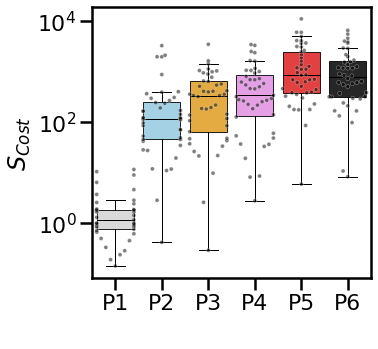

In [486]:
data_tbs=plot_cost_mul_shift_hist()
# plt.savefig('Fig_source_pnas/Stats/ShiftedCost_boxplot.png',dpi=200,bbox_inches='tight')

In [489]:
data_tbs

S_{Cost} Phase
41        0.857143    P1
139       1.000000    P1
199       3.714286    P1
324       0.952381    P1
361       0.238095    P1
...            ...   ...
14006  2883.750588    P6
14213     8.336642    P6
14292   641.496899    P6
14328  1172.536812    P6
14360   318.068901    P6

[260 rows x 2 columns]

In [503]:
for P in ['P1','P2','P3','P4','P5','P6']:
    print('\n'+P+'-- median:'+str(np.median(data_tbs.loc[data_tbs.Phase==P].loc[:,r'S_{Cost}'].values)))
    print('\n sum:'+str(data_tbs.loc[data_tbs.Phase==P].loc[:,r'S_{Cost}'].values.sum()))
    print('\n std:'+str(data_tbs.loc[data_tbs.Phase==P].loc[:,r'S_{Cost}'].values.std()))


P1-- median:1.1666666666666665

 sum:86.8843538095238

 std:2.6261286012140745

P2-- median:117.0

 sum:15057.559521666666

 std:672.5303948814545

P3-- median:335.47186071428575

 sum:21326.402351414283

 std:606.4853188939792

P4-- median:339.6474613636364

 sum:29385.621969772725

 std:833.1896119793088

P5-- median:857.9543011904761

 sum:77123.00619404762

 std:2135.678291730928

P6-- median:773.8696352941176

 sum:60393.67103811765

 std:1536.0293960005158


In [256]:
def plot_cost_hist():
    cost_matrixs=[]
    cost_matrix=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_01-31_03-13.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix.flatten())
    cost_matrix2=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_03-13_03-31.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix2.flatten())
    cost_matrix3=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_03-31_04-28.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix3.flatten())
    cost_matrix4=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_04-28_06-11.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix4.flatten())
    cost_matrix5=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_06-11_07-23.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix5.flatten())
    cost_matrix6=np.loadtxt("./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_07-23_08-09.csv",delimiter=',',skiprows=0)
    cost_matrixs.append(cost_matrix6.flatten())
    
    
    labels=['P1','P2','P3','P4','P5','P6']
    colors=['lightgrey','skyblue','orange','violet','red','black']
    
    hist_kwargs={"histtype": "step", "linewidth": 2,
                            "alpha": 0.8}
    kde_kws={"lw": 3,"alpha":0.6}
    
    f,ax=plt.subplots(1,1,figsize=(5,5))
    
    for i in range(0,len(cost_matrixs)):
        data_x=np.array(cost_matrixs[i]) 
        data_x=np.delete(data_x.flatten(), np.where(data_x.flatten()==0))
#         data_x=preprocessing.scale(data_x)
        sns.distplot(np.log10(data_x),rug=False, hist=True,kde=True,bins=10,kde_kws=kde_kws,hist_kws=hist_kwargs,ax=ax,label=labels[i],color=colors[i])

    ax.set_xlabel(r'$log_{10}$(Cost)')
    ax.set_ylabel(r'Density')
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.set_ylim([-10000,10000])
#     ax.set_xlim([5,1e4])
    plt.legend(bbox_to_anchor=(1, 0), loc='lower left',fontsize=10)

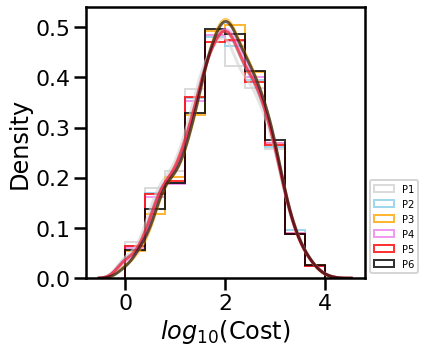

In [257]:
plot_cost_hist()

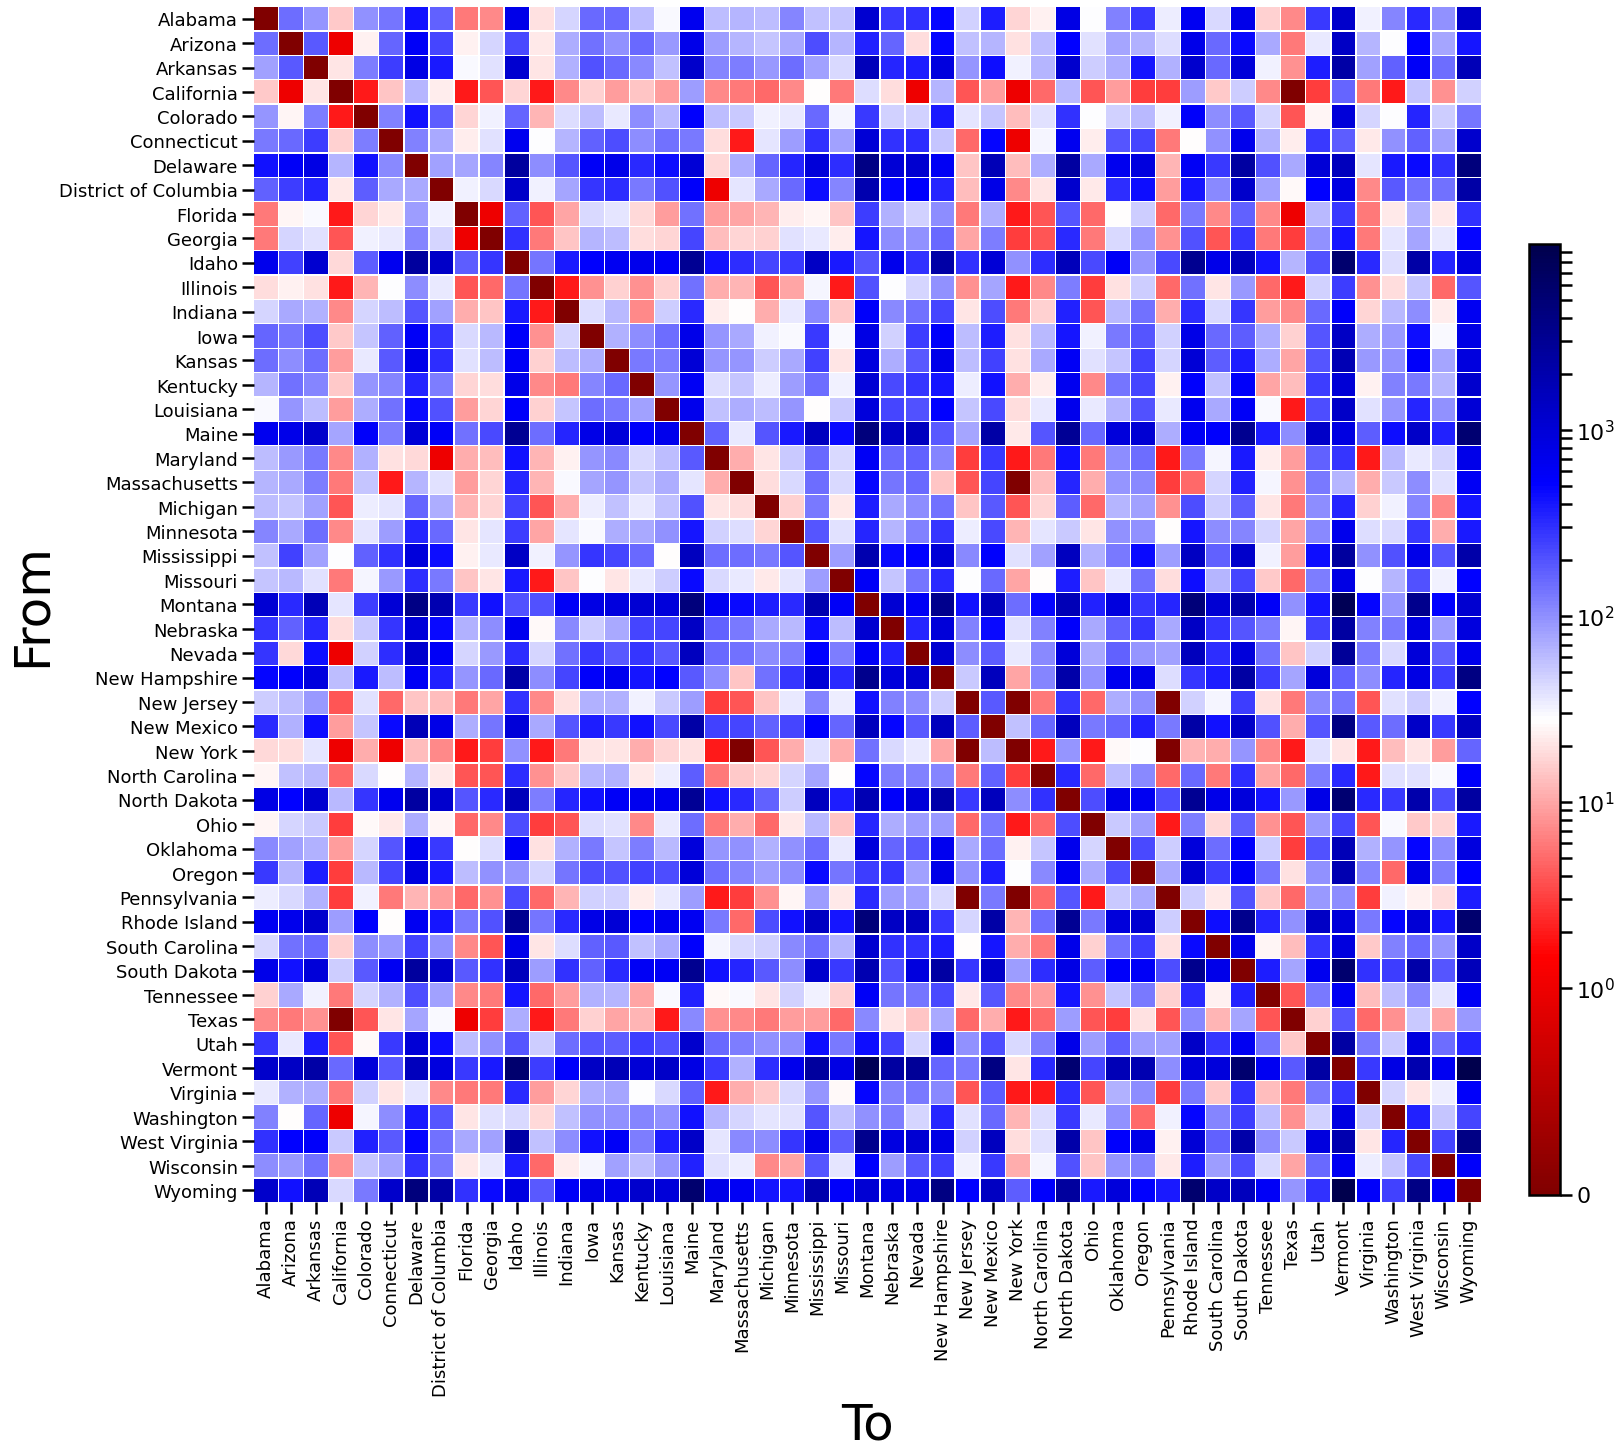

In [905]:
sns.set_context('poster')
plot_cost_matrix(state_df,t6,t7)
plt.savefig('Fig_source_pnas/CostMatrix_Adjusted_'+t6+'_'+t7+'.png',dpi=200,bbox_inches='tight')

### Some statistics for the paper writing

In [896]:
t1='01-31'
t2='03-13'
t3='03-31'
t4='04-28'
t5='06-11'
t6='07-23'
t7='08-09'
ts=[t1,t2,t3,t4,t5,t6,t7]

In [464]:
for i in range(0,len(ts)-1):
    shifts=np.loadtxt('./Flow_Matrix_Twitter_'+ts[i]+'_to_'+ts[i+1]+'.csv',delimiter=',',skiprows=0)
    costs=np.loadtxt('./movementmatricesbetweenstates/TwitterDerivedCostMatrix/Cost_Matrix_twitter_'+ts[i]+'_'+ts[i+1]+'.csv',delimiter=',',skiprows=0)
    cs=costs*shifts
    distance=np.genfromtxt('distancematrix_states/matrix_states.csv',delimiter=',',dtype=None)
    print('----------------------\nPhase: '+str(i+1))
    print('sum of shifts: '+str(shifts.sum()),
          '\nmax of shifts: '+str(shifts[np.where(shifts>0)].max()),
          '\nmean of shifts: '+str(shifts[np.where(shifts>0)].mean()),
          '\nfrom state of max shift: '+str(state_df.STATE_NAME[np.where(shifts==shifts[np.where(shifts>0)].max())[0]]),
          '\nto state of max shift: '+str(state_df.STATE_NAME[np.where(shifts==shifts[np.where(shifts>0)].max())[1]]),
          '\nmean of distance: '+str(np.array(distance).flatten()[np.where(shifts.flatten()!=0)].mean()),
          '\nmax of Scost: '+str(cs[np.where(cs>0)].max()),
          '\nmean of Scost: '+str(cs[np.where(cs>0)].mean()))

----------------------
Phase: 1
sum of shifts: 2393.0 
max of shifts: 486.71429 
mean of shifts: 50.91489361702128 
from state of max shift: 30    New York
Name: STATE_NAME, dtype: object 
to state of max shift: 11    Illinois
Name: STATE_NAME, dtype: object 
mean of distance: 868940.5531914893 
max of Scost: 486.71429 
mean of Scost: 89.0034843902439
----------------------
Phase: 2
sum of shifts: 156433.07354950003 
max of shifts: 58812.81 
mean of shifts: 3259.022365614583 
from state of max shift: 30    New York
Name: STATE_NAME, dtype: object 
to state of max shift: 3    California
Name: STATE_NAME, dtype: object 
mean of distance: 848568.1875 
max of Scost: 58812.81 
mean of Scost: 6303.164450930232
----------------------
Phase: 3
sum of shifts: 182616.2978793 
max of shifts: 27782.11 
mean of shifts: 3804.5062058187505 
from state of max shift: 19    Massachusetts
Name: STATE_NAME, dtype: object 
to state of max shift: 30    New York
Name: STATE_NAME, dtype: object 
mean of dista

In [443]:
def initialize_gis_all(t1,t2,t3,t4,t5,t6,t7):
    state=gpd.read_file('./COUNTY_dis2/COUNTY_dis2.shp')
    # state.head(5)
    columns=['STATE_FIPS','STATE_NAME','SUM_POP2_1','geometry']
    state_df=state[columns]
    state_df=state_df.dropna()
    pop_gdp=pd.read_csv('./COUNTY_dis2/state_pop_GDP_2019.csv')
    pop_gdp.columns=['Name','Postal Code','FIPS','POP2019','GDP2019million']

    state_df_all=state_df.merge(pop_gdp,left_on='STATE_NAME',right_on='Name',how='inner')[['STATE_FIPS','STATE_NAME','geometry','SUM_POP2_1','POP2019','GDP2019million']]

    columns_2=['FIPS','Province_State','Confirmed','Deaths']
    covdf1=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/'+t1+'_2020.csv')[columns_2]
    covdf2=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/'+t2+'_2020.csv')[columns_2]
    covdf3=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/'+t3+'_2020.csv')[columns_2]
    covdf4=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/'+t4+'_2020.csv')[columns_2]
    covdf5=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/'+t5+'_2020.csv')[columns_2]
    covdf6=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/'+t6+'_2020.csv')[columns_2]
    covdf7=pd.read_csv('covid_19_daily_reports_20200121_0811_State/reports/'+t7+'_2020.csv')[columns_2]
    
    covdfs=[covdf1,covdf2,covdf3,covdf4,covdf5,covdf6,covdf7]
    ts=[t1,t2,t3,t4,t5,t6,t7]

    for i,cov in enumerate(covdfs): 
        confirmed=state_df.merge(cov,left_on='STATE_NAME',right_on='Province_State',how="inner")['Confirmed']
        state_df_all[ts[i]]=confirmed
    return state_df_all

def plot_cc_distributions(state_df_all,ts):
    f,ax=plt.subplots(1,7,figsize=(30,15),dpi=300)
    for i,t in enumerate(ts):
        ax[i]=state_df_all.plot(column=t,cmap='OrRd',linewidth=1.6,edgecolor='white',norm=colors.SymLogNorm(linthresh=1,linscale=1,
                                                vmin=0, vmax=state_df_all[ts[6]].max(),base=10),legend=False,ax=ax[i])
        ax[i].set_title(ts[i])
        ax[i].set_axis_off()
    fig0 = ax[i].get_figure()
    cax0 = fig0.add_axes([0.9, 0.25, 0.01, 0.4])
    sm0 = plt.cm.ScalarMappable(cmap='OrRd', 
                            norm=colors.SymLogNorm(linthresh=1,linscale=1,
                                                vmin=0, vmax=state_df_all[ts[6]].max(),base=10))
    fig0.colorbar(sm0, cax=cax0)
    # add colorbar

#     fig0.colorbar(sm0, cax=cax0)
#     # add colorbar
#     fig1 = ax1.get_figure()
#     cax1 = fig1.add_axes([0.62, 0.35, 0.01, 0.2])
#     sm1 = plt.cm.ScalarMappable(cmap='Reds', 
#                                 norm=colors.SymLogNorm(linthresh=1,linscale=1,
#                                                     vmin=state_df.confirmed1.min(), vmax=state_df.confirmed1.max(),base=10))
#     fig1.colorbar(sm1, cax=cax1)
#     # add colorbar

#     fig2 = ax2.get_figure()
#     cax2 = fig2.add_axes([0.9, 0.35, 0.01, 0.2])
#     sm2 = plt.cm.ScalarMappable(cmap='Reds', 
#                                 norm=colors.SymLogNorm(linthresh=1,linscale=1,
#                                                     vmin=state_df.confirmed2.min(), vmax=state_df.confirmed2.max(),base=10))
#     fig2.colorbar(sm2, cax=cax2)
    # plt.savefig('./Fig_results_twitter/'+t1+'_to_'+t2+'distribution.png',dpi=200,bbox_inches='tight')


In [444]:
state_df_all=initialize_gis_all(t1,t2,t3,t4,t5,t6,t7)

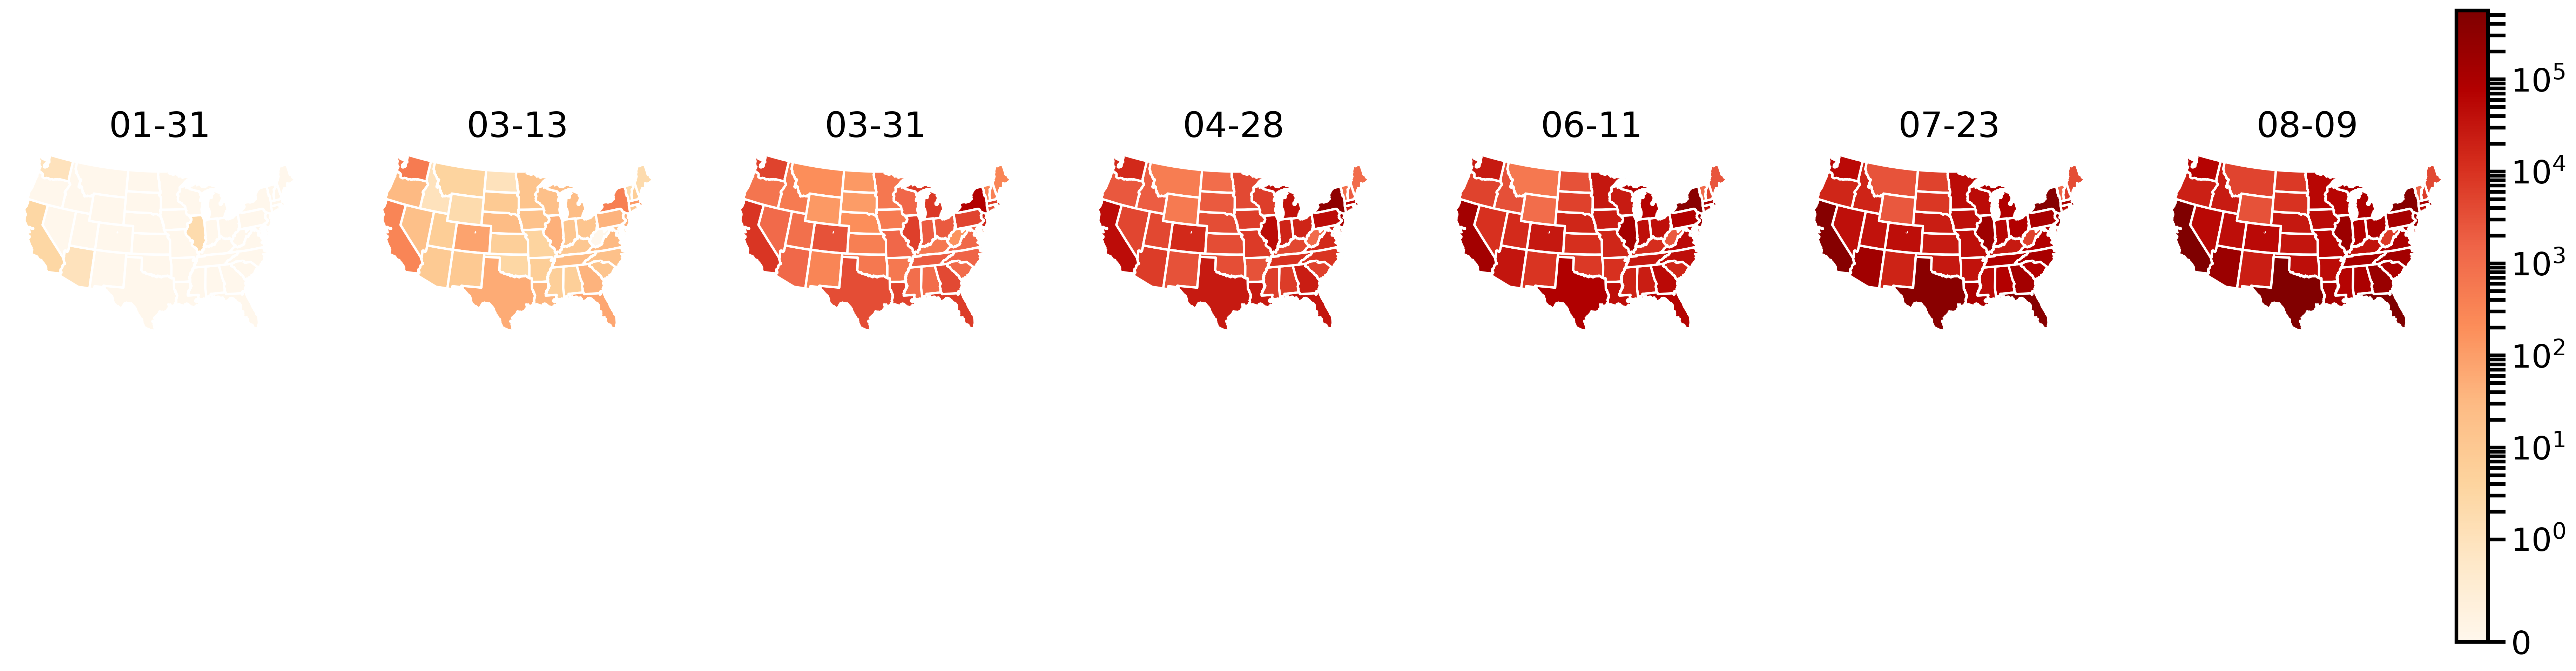

In [445]:
plot_cc_distributions(state_df_all,[t1,t2,t3,t4,t5,t6,t7])
# plt.savefig('Fig_source_pnas/ConfirmedCaseSnapshots.png',dpi=200,bbox_inches='tight')

In [574]:
STATE_NAME_S=['AL','AZ','AR','CA','CO','CT','DE','DC','FL','GA','ID','IL','IN',
             'IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE',
              'NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC',
             'SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

In [575]:
state_df_all['STATE_NAME_S']=STATE_NAME_S

In [800]:
def plot_rank_deltaconfirmedcase(state_df_all,t1,t2,p):
    # read confirmed case
    f,ax=plt.subplots(1,1,figsize=(4,6),dpi=300)
    deltaconfirmedcases=(state_df_all[t2]-state_df_all[t1]).values
    
    state_df_all['delta']=deltaconfirmedcases
    res = state_df_all.sort_values(by='delta', ascending=False)
    sns.barplot(x=res['delta'], y=res['STATE_NAME_S'], palette="Blues_d", ax=ax)
#     ax.set_yticklabels(res['STATE_NAME_S'],fontsize=4)
    ax.tick_params(axis='x', labelsize= 10)
    ax.tick_params(axis='y', labelsize= 6.5)
    ax.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(p)
    sns.despine()
    return res
def plot_USmap(data,p):
    f,ax=plt.subplots(1,1,figsize=(8,8),dpi=300)
    ax=data.plot(linewidth=1.6,edgecolor='white',legend=False,ax=ax)    
    ax.set_axis_off()
    ax.set_title(p)
    texts = []
    for x, y, label in zip(data.centroid.x-20000, data.centroid.y, data["STATE_NAME_S"]):
        ax.text(x, y, label, size=6)

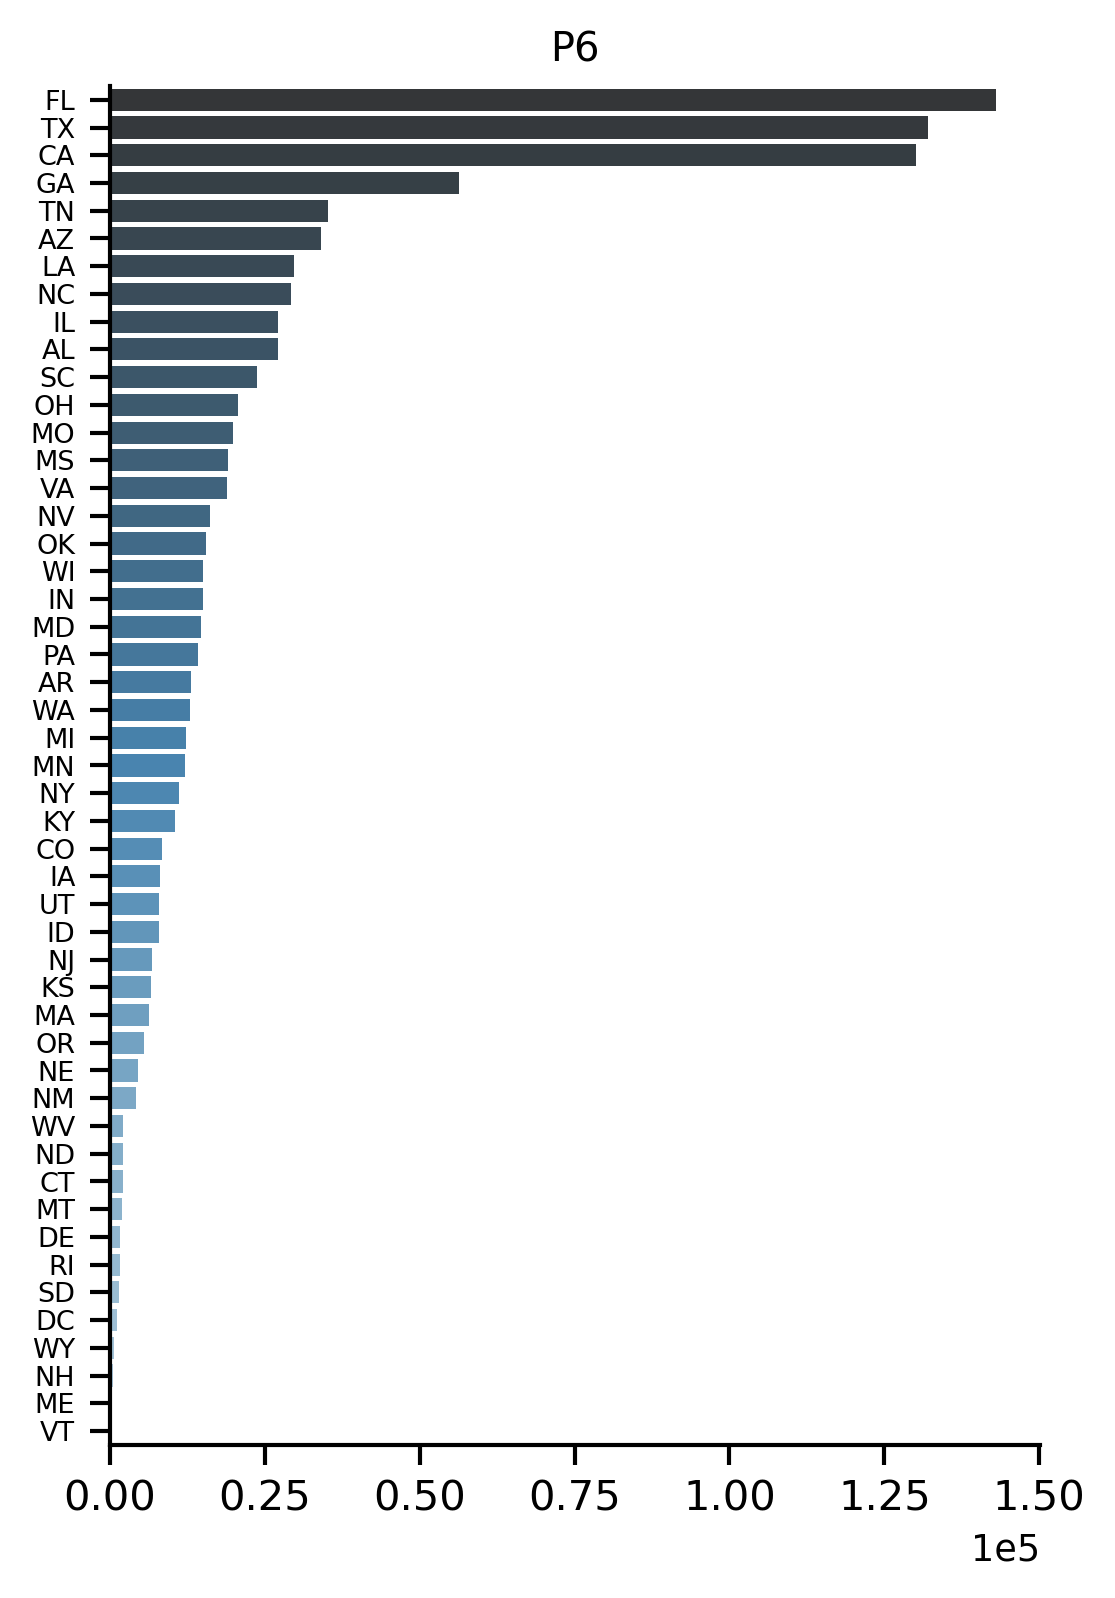

In [807]:
sns.set_context('paper')
res=plot_rank_deltaconfirmedcase(state_df_all,t6,t7,'P6')
plt.savefig('Fig_source_pnas/rank_cc_P6.png',dpi=200,bbox_inches='tight')

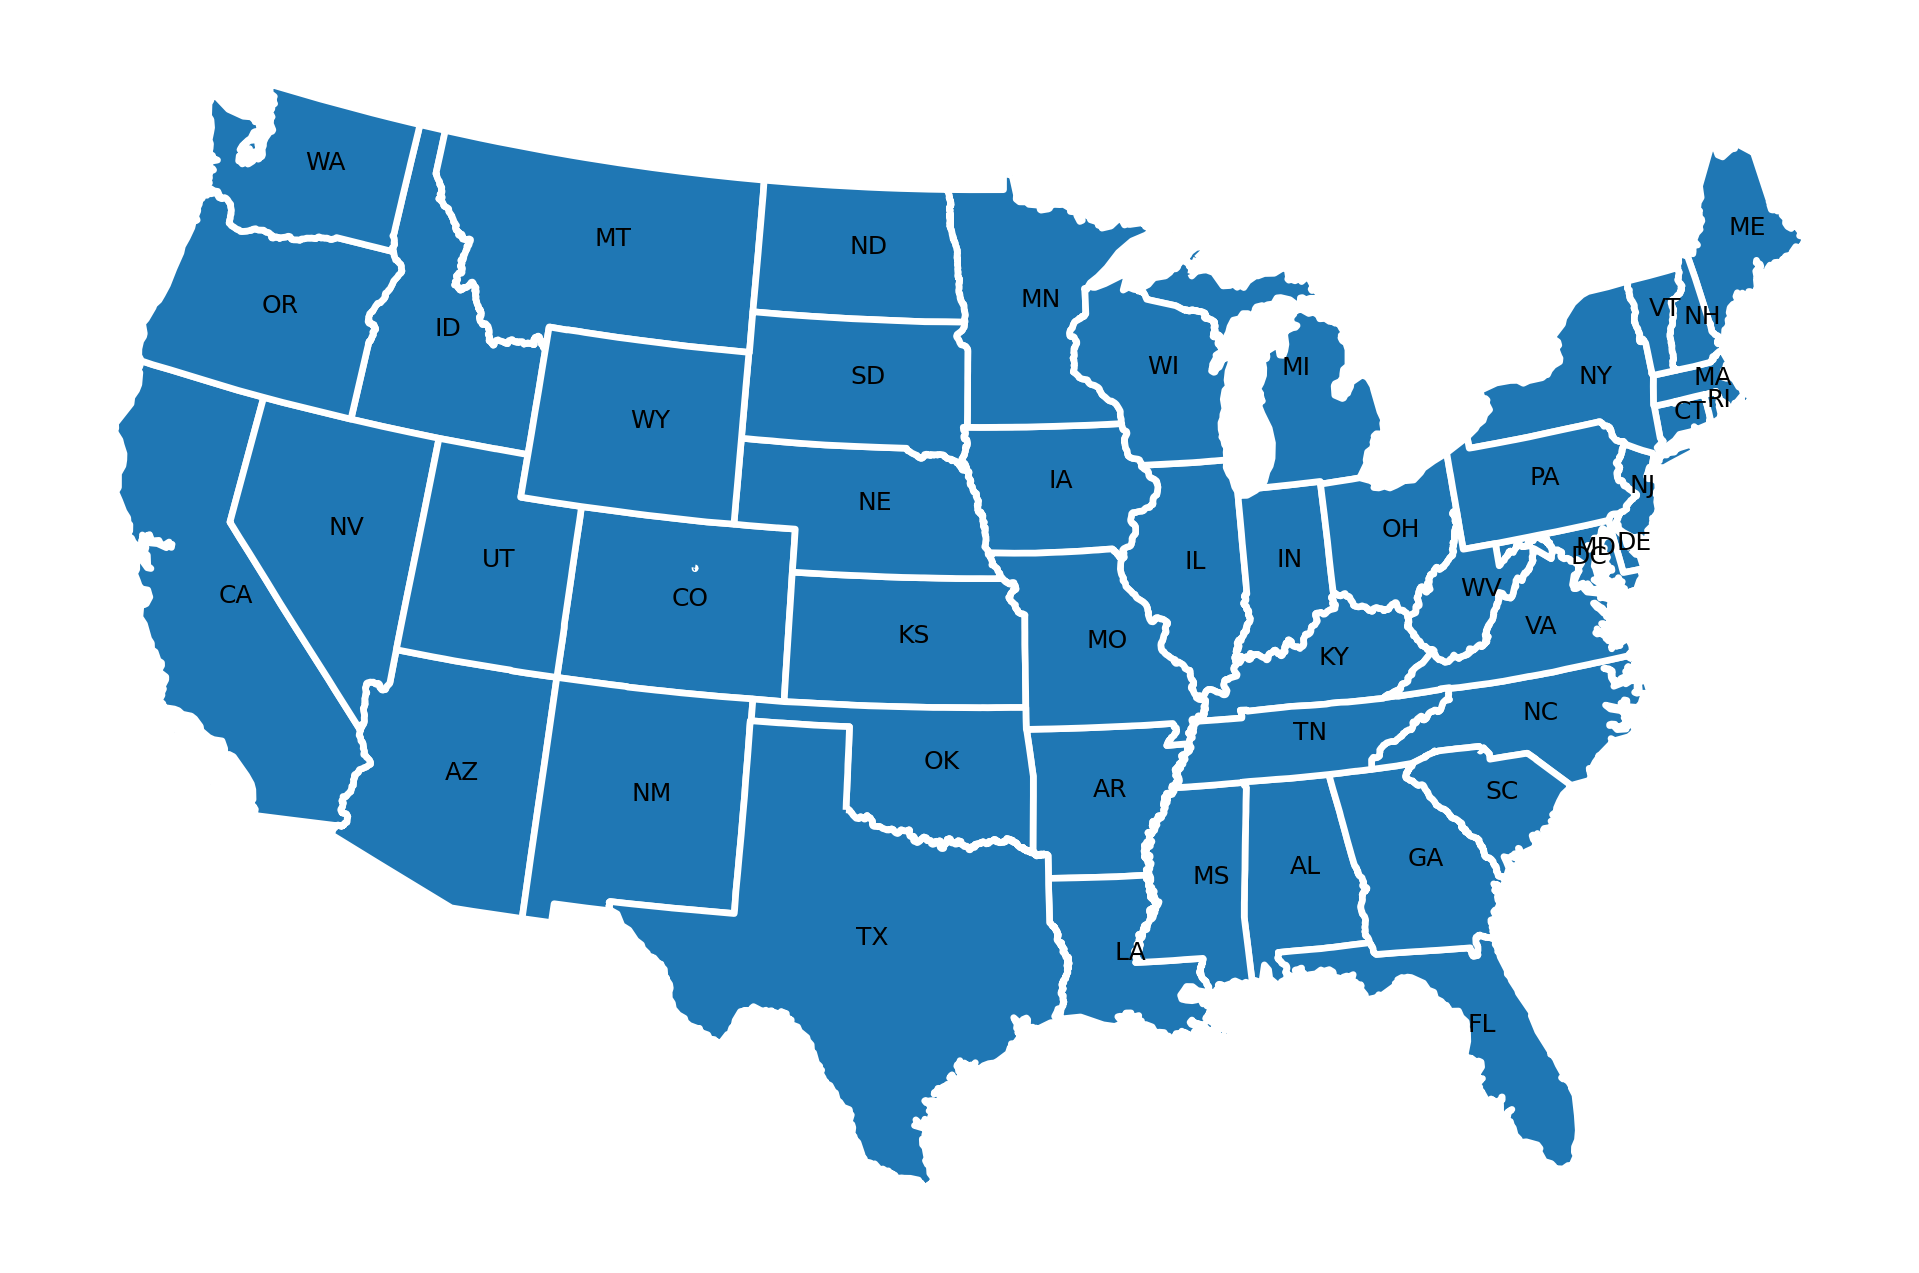

In [808]:
plot_USmap(state_df_all,'')

In [871]:
def plot_states_case_ts():
    path='./covid_19_daily_reports_20200121_0811_State/reports/'
    files=os.listdir(path)
    files=sorted(files)[1:]
    # for file in files:
    #     print(file)
    covdf_ts=pd.DataFrame()
    for file in files:
        covdf_ts=pd.concat([covdf_ts,pd.read_csv(path+file)])
    covdf_ts['date']=[ i[:-5] for i in covdf_ts['Last_Update']]
    
    f,ax=plt.subplots(1,1,figsize=(8,12))
    states_list=['California','New York','Florida','Texas','Illinois','New Jersey','Georgia','Massachusetts']
    
    count=0
    
    for i,state_name in enumerate(states_list):
        data_ts=covdf_ts.loc[covdf_ts.Province_State==state_name][10:]
        sns.lineplot(x=range(0,data_ts.shape[0]),y="Confirmed",data=data_ts,linewidth=5,alpha=0.5,ax=ax,label=state_name)

    ax.xaxis.set_minor_locator(MultipleLocator(7))
    ax.set_xlim([-1,194])
    ax.set_ylabel('Total Confirmed Cases')
    # ax.set_yscale('log')
    sns.despine(offset=30, left=0)
    # scales=[42,18,28,44,42,17]
    plt.xticks([0,42,60,88,132,174,191],(['Jan 31','Mar 13','Mar 31','Apr 28','Jun 11','Jul 23','Aug 09']),fontsize=20)
    ax.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    ax.tick_params(axis='x',rotation=45,labelsize= 15)
    ax.legend(fontsize='20')

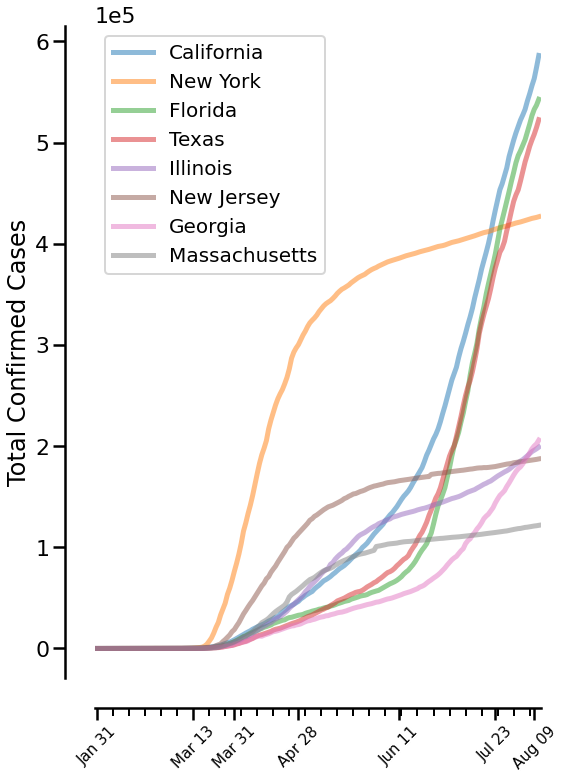

In [872]:
sns.set_context('poster')
plot_states_case_ts()
plt.savefig('Fig_source_pnas/Stats/State_ConfirmedCaseSnapshots.png',dpi=200,bbox_inches='tight')

In [933]:
def plot_sum_meandist_shift():
    x=[(0+42)/2,(42+60)/2,(60+88)/2,(88+132)/2,(132+174)/2,(174+191)/2]
    y_shiftsum=[2.3e3,1.56e5,1.83e5,6.63e5,2e6,4.77e5]
    y_distmean=[868.91,848.57,789.59,776.40,828.57,831.60]
    f,ax=plt.subplots(1,1,figsize=(10,6))
    sns.scatterplot(x,y_shiftsum,color='red',ax=ax)
    sns.lineplot(x,y_shiftsum,color='red',ax=ax,label='Shift')

    ax2 = ax.twinx()
    sns.scatterplot(x,y_distmean,color='blue',ax=ax2)
    sns.lineplot(x,y_distmean,color='blue',ax=ax2,label='Distance')

    ax.set_xlim([-1,194])
    ax.set_ylabel('Total Intensity of Shifts',fontsize=20)
    ax2.set_ylabel('Mean Distance of Shifts ('+r'$km$'+')',fontsize=20)
    # ax.set_yscale('log')
    # scales=[42,18,28,44,42,17]
    plt.xticks(x,(['P1','P2','P3','P4','P5','P6']),fontsize=20)

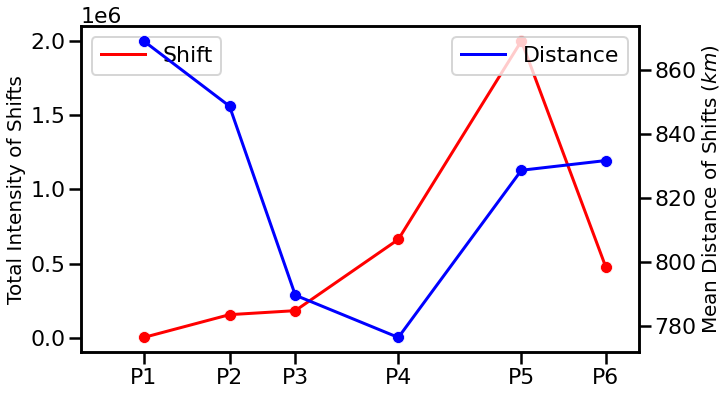

In [934]:
sns.set_context('poster')
plot_sum_meandist_shift()
plt.savefig('Fig_source_pnas/Stats/sum_meandist_shift_all.png',dpi=200,bbox_inches='tight')